In [22]:
from __future__ import print_function
import pickle
# from sms import sendMessage
import os
import sys
import matplotlib.pyplot as plt
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from model import capsules
from loss import SpreadLoss
from torch import utils
from torch.utils.data import Dataset, TensorDataset, DataLoader
#########################
seed = 1
cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
#########################
batch_size, test_batch_size =128 , 200
init_lr = 1e-3 # moein - according to openreview
weight_decay = 2e-6  # moein - according to openreview
log_interval = 50
test_interval = 1
epochs = 200
snapshot_folder = 'FMnist_weights'
test_code = False # moein - for checking the functions. If True, model will run one step.
log_test = False # moein - for getting logs
small_data = False
#########################

In [23]:
from sklearn.model_selection import train_test_split

def get_setting(size= [80,80]):
    kwargs = {'num_workers': 1, 'pin_memory': True}
    
    train_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('data', train=True, download=True,
                            transform=transforms.Compose([
                            transforms.Resize(size=(size[0],size[1])),
                            transforms.ToTensor(),
#                             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                           ])),batch_size=batch_size, shuffle=False, **kwargs)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('data', train=False, 
                           transform=transforms.Compose([
                            transforms.Resize(size=(size[0],size[1])),
                           transforms.ToTensor(),
#                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                           ])),batch_size=test_batch_size, shuffle=True, **kwargs)
    
    return train_loader, test_loader

In [24]:
image_size = 24 #40
train_loader, test_loader = get_setting([image_size,image_size])
num_class = len(train_loader.dataset.classes)
print(len(train_loader)*batch_size,len(test_loader)*test_batch_size,num_class)
print(train_loader.dataset[0][0].shape)

60032 10000 10
torch.Size([1, 24, 24])


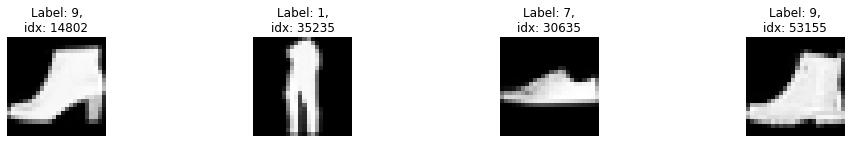

In [4]:
import random
def plot_gallery(imgs,image_size,num=4,class_idx=False):
    plt.figure(figsize=(15,6))
    for idx in range(num) :
        if class_idx:
            i = idx
        else:
            rand = random.randint(1,len(imgs))
            i = idx+rand
        img_ = imgs[i][0]
        label = imgs[i][1]
        plt.subplot(1, num, idx+1)
        plt.axis('off')
        plt.imshow(img_.reshape(img_.shape[1],img_.shape[2]),cmap='Greys_r')
        plt.subplots_adjust(wspace=1.5)
        plt.title("Label: {0},\nidx: {1}".format(label,i))

plot_gallery(train_loader.dataset,image_size,class_idx=False)

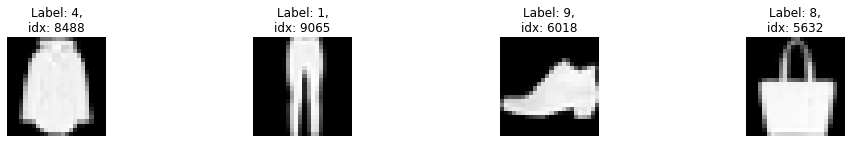

In [5]:
plot_gallery(test_loader.dataset,image_size,class_idx=False)

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(train_loader, model, criterion, optimizer, epoch, device, previous_epochs=0, ext_decay= 1):
    
    ''' * exponential learning rate decay added'''
    
    batch_time = AverageMeter()
    data_time = AverageMeter()

    model.train()
    train_len = len(train_loader)
    epoch_acc,epoch_loss = 0,0
    i=0
    for batch_idx, (data, target) in enumerate(train_loader):
        if i > 2 and small_data :
            break;
        if batch_idx == 1 and small_data :
            print(target[0])
        
        i += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        r = (1.*batch_idx + (previous_epochs+epoch-1) * train_len) / ((previous_epochs+epochs)*train_len) # moein - used in criterion
        
        loss = criterion(output, target, r)        
        acc = accuracy(output, target)
        
        global_step = (batch_idx+1) + (previous_epochs + epoch - 1) * len(train_loader) # moein
        exp_lr_decay(optimizer = optimizer, global_step = global_step, ext_decay = ext_decay,init_lr=init_lr) # moein - change the learning rate exponentially
        
        if log_test:
            for param_group in optimizer.param_groups:
                print('optim lr:',param_group['lr'])
                print('step:',global_step)
        
        loss.backward()
        optimizer.step()
        epoch_acc += acc[0].item()
        epoch_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}\t[{}/{} ({:.0f}%)]\t'
                  'Loss: {:.6f}\tAccuracy: {:.6f}\t'.format(
                  epoch+previous_epochs, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item(), acc[0].item()))
            
        if test_code: return epoch_acc,epoch_loss

    return epoch_acc,epoch_loss

def test(test_loader, model, criterion, device):
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        i = 0
        for data, target in test_loader:
            progressBar(job='Test',value=i, endvalue=test_len); i += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, r=1).item()
            acc += accuracy(output, target)[0].item()
            if test_code: return acc

    test_loss /= test_len
    acc /= test_len
    print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))
    return acc


In [7]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def snapshot(model, folder, epoch, name):
    path = os.path.join(folder, 'model_{}_{}.pth'.format(name,epoch))
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    print('\nsaving model to {}'.format(path))
    torch.save(model.state_dict(), path)
    
def exp_lr_decay(optimizer, global_step, init_lr = 3e-3, decay_steps = 20000,
                                        decay_rate = 0.96, lr_clip = 3e-3 ,ext_decay = 1, staircase=False):
    
    ''' decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)  '''
    
    if staircase:
        lr = (init_lr * decay_rate**(global_step // decay_steps)) * ext_decay
    else:
        lr = (init_lr * decay_rate**(global_step / decay_steps)) * ext_decay
    
#     lr = min(lr, lr_clip)

#     if global_step % decay_steps == 0:
#         print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [8]:
def mainTrain(name, epochs, model, history, optimizer, tolarance = 12, 
              previous_epochs = 0, best_acc= 0, init_decay_fac = 1,LR_decay_fac= 0.1 , best_epoch = 1):
    best_acc = best_acc
    best_epoch = best_epoch
    t, t1 = tolarance , tolarance
    noImp = 0
    test_acc =0
    decay_factor = init_decay_fac # moein - when training reaches the tolarance threshold, lr will be multiplied by this.
                                # inintial value of it is 1
    print('########### Training model {} ###########'.format(name))
    for epoch in range(1, epochs + 1):
        start=time.time()
        noImp = (epoch + previous_epochs) - best_epoch
        
        acc,loss = train(train_loader, model, criterion, optimizer, epoch, device, previous_epochs,ext_decay=decay_factor)
        acc /= len(train_loader)
        loss /=len(train_loader)

        history['acc'].append(acc)        
        print('Epoch Train-loss : {:.4f}, Epoch Train-accuracy : {:.4f}'.format(loss,acc))
                
        if epoch % test_interval == 0:
            test_acc = test(test_loader, model, criterion, device)
            history['val_acc'].append(test_acc)
            best_acc = max(best_acc,test_acc )
            
            
        snapshot(model, snapshot_folder, epoch+previous_epochs,name)
        
        end=time.time()
        for param_group in optimizer.param_groups:
            print('Current Learning Rate : {}'.format(param_group['lr']))
        
        
        if test_code == True: return best_acc
            
        if test_acc < best_acc:
            tolarance -= 1
            if tolarance < 0:
                print('{} epochs with no improvement since the multiplication. Multiplying LR by {}'.format(t,LR_decay_fac))
                t=t//2 
                if t<4: t += 3
                tolarance = t # moein - reset tolarence
                decay_factor *= LR_decay_fac 
        else :
            best_epoch = epoch + previous_epochs
            tolarance = t
            
        print('* Best val Accuracy so far : {:.3f} epoch : {} *'.format(best_acc,best_epoch))
        print('Total {} epochs with no improvement in val_acc.'.format(noImp))
        
        if noImp == 25 :
            print('Model has converged. Existing the training.')
            return best_acc
        
        print('Epoch time: {:.2f} mins'.format((end-start)/60))
        print('='*80)

    print('########### Training model {} finished ###########'.format(name))
    return best_acc

In [9]:
device = torch.device("cuda" if cuda else "cpu")
A, B, C, D = 64, 8, 16, 16
# A, B, C, D = 32, 8, 8, 8

criterion = SpreadLoss(num_class=num_class, m_min=0.2, m_max=0.9)

In [ ]:
stop

------------------------------------------------------------------------------------

#### model 212


In [19]:
# model
torch.cuda.empty_cache()    
best_acc212 = 0
em_iters = [2,1,2]
model212 = capsules(A=A, B=B, C=C, D=D, E=num_class,in_channels=1,
                 iters_routings=em_iters).to(device)
history212={'val_acc':[],'acc':[]}
optimizer212 = optim.Adam(model212.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 10, 3, 4, 1] 
iters for routings:  [2, 1, 2] 
stage output:  class_caps 
activation:  o


In [20]:
best_acc212= mainTrain('model212_A',epochs,model212,history212,optimizer212)

########### Training model model212_A ###########
Train Epoch: 1	[0/60000 (0%)]	Loss: 0.461554	Accuracy: 11.718750	
Train Epoch: 1	[6400/60000 (11%)]	Loss: 0.093198	Accuracy: 64.062500	
Train Epoch: 1	[12800/60000 (21%)]	Loss: 0.050377	Accuracy: 76.562500	
Train Epoch: 1	[19200/60000 (32%)]	Loss: 0.065909	Accuracy: 68.750000	
Train Epoch: 1	[25600/60000 (43%)]	Loss: 0.044680	Accuracy: 80.468750	
Train Epoch: 1	[32000/60000 (53%)]	Loss: 0.044744	Accuracy: 80.468750	
Train Epoch: 1	[38400/60000 (64%)]	Loss: 0.042010	Accuracy: 78.906250	
Train Epoch: 1	[44800/60000 (75%)]	Loss: 0.042113	Accuracy: 81.250000	
Train Epoch: 1	[51200/60000 (85%)]	Loss: 0.047881	Accuracy: 82.031250	
Train Epoch: 1	[57600/60000 (96%)]	Loss: 0.036359	Accuracy: 79.687500	
Epoch Train-loss : 0.0616, Epoch Train-accuracy : 74.6391
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.987389, Accuracy: 79.704159 


saving model to FMnist_weights\model_model212_A_1.pth
Current Learning Rate : 0.0009990

Train Epoch: 8	[6400/60000 (11%)]	Loss: 0.036696	Accuracy: 85.937500	
Train Epoch: 8	[12800/60000 (21%)]	Loss: 0.023833	Accuracy: 89.062500	
Train Epoch: 8	[19200/60000 (32%)]	Loss: 0.034981	Accuracy: 86.718750	
Train Epoch: 8	[25600/60000 (43%)]	Loss: 0.020857	Accuracy: 89.843750	
Train Epoch: 8	[32000/60000 (53%)]	Loss: 0.032898	Accuracy: 83.593750	
Train Epoch: 8	[38400/60000 (64%)]	Loss: 0.028347	Accuracy: 90.625000	
Train Epoch: 8	[44800/60000 (75%)]	Loss: 0.036033	Accuracy: 83.593750	
Train Epoch: 8	[51200/60000 (85%)]	Loss: 0.035054	Accuracy: 89.843750	
Train Epoch: 8	[57600/60000 (96%)]	Loss: 0.022991	Accuracy: 87.500000	
Epoch Train-loss : 0.0273, Epoch Train-accuracy : 88.2840
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.307901, Accuracy: 86.427504 


saving model to FMnist_weights\model_model212_A_8.pth
Current Learning Rate : 0.000992371043175416
* Best val Accuracy so far : 86.428 epoch : 8 *
Total 1 epochs with no improvement in val_acc.
Epoch tim

Train Epoch: 15	[12800/60000 (21%)]	Loss: 0.022369	Accuracy: 89.062500	
Train Epoch: 15	[19200/60000 (32%)]	Loss: 0.031331	Accuracy: 90.625000	
Train Epoch: 15	[25600/60000 (43%)]	Loss: 0.021751	Accuracy: 93.750000	
Train Epoch: 15	[32000/60000 (53%)]	Loss: 0.031681	Accuracy: 87.500000	
Train Epoch: 15	[38400/60000 (64%)]	Loss: 0.029317	Accuracy: 92.187500	
Train Epoch: 15	[44800/60000 (75%)]	Loss: 0.037035	Accuracy: 86.718750	
Train Epoch: 15	[51200/60000 (85%)]	Loss: 0.030252	Accuracy: 92.968750	
Train Epoch: 15	[57600/60000 (96%)]	Loss: 0.023785	Accuracy: 89.843750	
Epoch Train-loss : 0.0260, Epoch Train-accuracy : 90.5945
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.064393, Accuracy: 87.878561 


saving model to FMnist_weights\model_model212_A_15.pth
Current Learning Rate : 0.0009857434641560286
* Best val Accuracy so far : 87.879 epoch : 15 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 5.51 mins
Train Epoch: 16	[0/60000 (0%)]	Loss: 0.015301	

Train Epoch: 22	[12800/60000 (21%)]	Loss: 0.021072	Accuracy: 92.187500	
Train Epoch: 22	[19200/60000 (32%)]	Loss: 0.028369	Accuracy: 91.406250	
Train Epoch: 22	[25600/60000 (43%)]	Loss: 0.019944	Accuracy: 95.312500	
Train Epoch: 22	[32000/60000 (53%)]	Loss: 0.032960	Accuracy: 89.843750	
Train Epoch: 22	[38400/60000 (64%)]	Loss: 0.030316	Accuracy: 92.968750	
Train Epoch: 22	[44800/60000 (75%)]	Loss: 0.037698	Accuracy: 88.281250	
Train Epoch: 22	[51200/60000 (85%)]	Loss: 0.029275	Accuracy: 94.531250	
Train Epoch: 22	[57600/60000 (96%)]	Loss: 0.026874	Accuracy: 90.625000	
Epoch Train-loss : 0.0264, Epoch Train-accuracy : 92.0298
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.881739, Accuracy: 88.829274 


saving model to FMnist_weights\model_model212_A_22.pth
Current Learning Rate : 0.00097916014761685
* Best val Accuracy so far : 88.864 epoch : 21 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 5.50 mins
Train Epoch: 23	[0/60000 (0%)]	Loss: 0.014796	Ac

Train Epoch: 29	[12800/60000 (21%)]	Loss: 0.020805	Accuracy: 95.312500	
Train Epoch: 29	[19200/60000 (32%)]	Loss: 0.028761	Accuracy: 92.968750	
Train Epoch: 29	[25600/60000 (43%)]	Loss: 0.020314	Accuracy: 96.093750	
Train Epoch: 29	[32000/60000 (53%)]	Loss: 0.033626	Accuracy: 89.843750	
Train Epoch: 29	[38400/60000 (64%)]	Loss: 0.030700	Accuracy: 92.968750	
Train Epoch: 29	[44800/60000 (75%)]	Loss: 0.038740	Accuracy: 88.281250	
Train Epoch: 29	[51200/60000 (85%)]	Loss: 0.029587	Accuracy: 96.093750	
Train Epoch: 29	[57600/60000 (96%)]	Loss: 0.032080	Accuracy: 92.187500	
Epoch Train-loss : 0.0273, Epoch Train-accuracy : 93.0726
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.711573, Accuracy: 89.186006 


saving model to FMnist_weights\model_model212_A_29.pth
Current Learning Rate : 0.000972620797949612
* Best val Accuracy so far : 89.186 epoch : 29 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 5.51 mins
Train Epoch: 30	[0/60000 (0%)]	Loss: 0.015232	A

Train Epoch: 36	[12800/60000 (21%)]	Loss: 0.021179	Accuracy: 96.093750	
Train Epoch: 36	[19200/60000 (32%)]	Loss: 0.030706	Accuracy: 94.531250	
Train Epoch: 36	[25600/60000 (43%)]	Loss: 0.023255	Accuracy: 95.312500	
Train Epoch: 36	[32000/60000 (53%)]	Loss: 0.033928	Accuracy: 89.843750	
Train Epoch: 36	[38400/60000 (64%)]	Loss: 0.029669	Accuracy: 93.750000	
Train Epoch: 36	[44800/60000 (75%)]	Loss: 0.039500	Accuracy: 89.062500	
Train Epoch: 36	[51200/60000 (85%)]	Loss: 0.027917	Accuracy: 96.093750	
Train Epoch: 36	[57600/60000 (96%)]	Loss: 0.035564	Accuracy: 91.406250	
Epoch Train-loss : 0.0282, Epoch Train-accuracy : 94.0465
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.586887, Accuracy: 89.502528 


saving model to FMnist_weights\model_model212_A_36.pth
Current Learning Rate : 0.0009661251215202755
* Best val Accuracy so far : 89.503 epoch : 36 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 5.50 mins
Train Epoch: 37	[0/60000 (0%)]	Loss: 0.015196	

Train Epoch: 43	[12800/60000 (21%)]	Loss: 0.022459	Accuracy: 96.093750	
Train Epoch: 43	[19200/60000 (32%)]	Loss: 0.028780	Accuracy: 96.093750	
Train Epoch: 43	[25600/60000 (43%)]	Loss: 0.026611	Accuracy: 94.531250	
Train Epoch: 43	[32000/60000 (53%)]	Loss: 0.036326	Accuracy: 92.187500	
Train Epoch: 43	[38400/60000 (64%)]	Loss: 0.029306	Accuracy: 94.531250	
Train Epoch: 43	[44800/60000 (75%)]	Loss: 0.043184	Accuracy: 89.843750	
Train Epoch: 43	[51200/60000 (85%)]	Loss: 0.027707	Accuracy: 96.093750	
Train Epoch: 43	[57600/60000 (96%)]	Loss: 0.036137	Accuracy: 92.968750	
Epoch Train-loss : 0.0290, Epoch Train-accuracy : 94.8605
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.494309, Accuracy: 89.595014 


saving model to FMnist_weights\model_model212_A_43.pth
Current Learning Rate : 0.0009596728266558442
* Best val Accuracy so far : 89.645 epoch : 41 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 5.50 mins
Train Epoch: 44	[0/60000 (0%)]	Loss: 0.015134	

Train Epoch: 50	[12800/60000 (21%)]	Loss: 0.023169	Accuracy: 96.875000	
Train Epoch: 50	[19200/60000 (32%)]	Loss: 0.028502	Accuracy: 96.875000	
Train Epoch: 50	[25600/60000 (43%)]	Loss: 0.028667	Accuracy: 96.093750	
Train Epoch: 50	[32000/60000 (53%)]	Loss: 0.041506	Accuracy: 92.968750	
Train Epoch: 50	[38400/60000 (64%)]	Loss: 0.028968	Accuracy: 95.312500	
Train Epoch: 50	[44800/60000 (75%)]	Loss: 0.043216	Accuracy: 90.625000	
Train Epoch: 50	[51200/60000 (85%)]	Loss: 0.028714	Accuracy: 97.656250	
Train Epoch: 50	[57600/60000 (96%)]	Loss: 0.037548	Accuracy: 94.531250	
Epoch Train-loss : 0.0296, Epoch Train-accuracy : 95.6723
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.432885, Accuracy: 89.483571 


saving model to FMnist_weights\model_model212_A_50.pth
Current Learning Rate : 0.0009532636236312693
* Best val Accuracy so far : 89.645 epoch : 41 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 5.50 mins
Train Epoch: 51	[0/60000 (0%)]	Loss: 0.016841	

Train Epoch: 57	[12800/60000 (21%)]	Loss: 0.022218	Accuracy: 96.875000	
Train Epoch: 57	[19200/60000 (32%)]	Loss: 0.027087	Accuracy: 97.656250	
Train Epoch: 57	[25600/60000 (43%)]	Loss: 0.030263	Accuracy: 96.875000	
Train Epoch: 57	[32000/60000 (53%)]	Loss: 0.049831	Accuracy: 92.187500	
Train Epoch: 57	[38400/60000 (64%)]	Loss: 0.028781	Accuracy: 95.312500	
Train Epoch: 57	[44800/60000 (75%)]	Loss: 0.044234	Accuracy: 92.187500	
Train Epoch: 57	[51200/60000 (85%)]	Loss: 0.028578	Accuracy: 97.656250	
Train Epoch: 57	[57600/60000 (96%)]	Loss: 0.038864	Accuracy: 95.312500	
Epoch Train-loss : 0.0302, Epoch Train-accuracy : 96.3869
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.376967, Accuracy: 89.605928 


saving model to FMnist_weights\model_model212_A_57.pth
Current Learning Rate : 0.0009468972246564383
* Best val Accuracy so far : 89.715 epoch : 52 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 5.51 mins
Train Epoch: 58	[0/60000 (0%)]	Loss: 0.016837	

Train Epoch: 64	[12800/60000 (21%)]	Loss: 0.023960	Accuracy: 97.656250	
Train Epoch: 64	[19200/60000 (32%)]	Loss: 0.026806	Accuracy: 99.218750	
Train Epoch: 64	[25600/60000 (43%)]	Loss: 0.032725	Accuracy: 96.875000	
Train Epoch: 64	[32000/60000 (53%)]	Loss: 0.048532	Accuracy: 93.750000	
Train Epoch: 64	[38400/60000 (64%)]	Loss: 0.029904	Accuracy: 96.093750	
Train Epoch: 64	[44800/60000 (75%)]	Loss: 0.047288	Accuracy: 93.750000	
Train Epoch: 64	[51200/60000 (85%)]	Loss: 0.028377	Accuracy: 96.875000	
Train Epoch: 64	[57600/60000 (96%)]	Loss: 0.038221	Accuracy: 96.093750	
Epoch Train-loss : 0.0311, Epoch Train-accuracy : 97.0688
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.326173, Accuracy: 89.270450 


saving model to FMnist_weights\model_model212_A_64.pth
Current Learning Rate : 0.0009405733438632542
* Best val Accuracy so far : 89.715 epoch : 52 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 5.50 mins
Train Epoch: 65	[0/60000 (0%)]	Loss: 0.017897

Train Epoch: 71	[6400/60000 (11%)]	Loss: 0.044891	Accuracy: 93.750000	
Train Epoch: 71	[12800/60000 (21%)]	Loss: 0.025766	Accuracy: 98.437500	
Train Epoch: 71	[19200/60000 (32%)]	Loss: 0.028227	Accuracy: 99.218750	
Train Epoch: 71	[25600/60000 (43%)]	Loss: 0.038624	Accuracy: 96.875000	
Train Epoch: 71	[32000/60000 (53%)]	Loss: 0.050358	Accuracy: 93.750000	
Train Epoch: 71	[38400/60000 (64%)]	Loss: 0.039206	Accuracy: 98.437500	
Train Epoch: 71	[44800/60000 (75%)]	Loss: 0.049053	Accuracy: 92.968750	
Train Epoch: 71	[51200/60000 (85%)]	Loss: 0.030328	Accuracy: 99.218750	
Train Epoch: 71	[57600/60000 (96%)]	Loss: 0.039961	Accuracy: 96.093750	
Epoch Train-loss : 0.0345, Epoch Train-accuracy : 97.5563
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.252546, Accuracy: 89.861558 


saving model to FMnist_weights\model_model212_A_71.pth
Current Learning Rate : 9.342916972927977e-05
* Best val Accuracy so far : 90.007 epoch : 68 *
Total 3 epochs with no improvement in val_ac

Train Epoch: 78	[0/60000 (0%)]	Loss: 0.026782	Accuracy: 99.218750	
Train Epoch: 78	[6400/60000 (11%)]	Loss: 0.058085	Accuracy: 95.312500	
Train Epoch: 78	[12800/60000 (21%)]	Loss: 0.033737	Accuracy: 98.437500	
Train Epoch: 78	[19200/60000 (32%)]	Loss: 0.040551	Accuracy: 98.437500	
Train Epoch: 78	[25600/60000 (43%)]	Loss: 0.047577	Accuracy: 96.875000	
Train Epoch: 78	[32000/60000 (53%)]	Loss: 0.061528	Accuracy: 92.968750	
Train Epoch: 78	[38400/60000 (64%)]	Loss: 0.048011	Accuracy: 97.656250	
Train Epoch: 78	[44800/60000 (75%)]	Loss: 0.059125	Accuracy: 92.968750	
Train Epoch: 78	[51200/60000 (85%)]	Loss: 0.039435	Accuracy: 98.437500	
Train Epoch: 78	[57600/60000 (96%)]	Loss: 0.048389	Accuracy: 96.875000	
Epoch Train-loss : 0.0438, Epoch Train-accuracy : 97.7279
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.227517, Accuracy: 89.943129 


saving model to FMnist_weights\model_model212_A_78.pth
Current Learning Rate : 9.28052002882578e-06
* Best val Accuracy so far 

Train Epoch: 85	[0/60000 (0%)]	Loss: 0.041793	Accuracy: 99.218750	
Train Epoch: 85	[6400/60000 (11%)]	Loss: 0.078202	Accuracy: 95.312500	
Train Epoch: 85	[12800/60000 (21%)]	Loss: 0.049361	Accuracy: 98.437500	
Train Epoch: 85	[19200/60000 (32%)]	Loss: 0.057691	Accuracy: 98.437500	
Train Epoch: 85	[25600/60000 (43%)]	Loss: 0.065637	Accuracy: 96.875000	
Train Epoch: 85	[32000/60000 (53%)]	Loss: 0.082278	Accuracy: 92.968750	
Train Epoch: 85	[38400/60000 (64%)]	Loss: 0.069151	Accuracy: 97.656250	
Train Epoch: 85	[44800/60000 (75%)]	Loss: 0.082124	Accuracy: 92.968750	
Train Epoch: 85	[51200/60000 (85%)]	Loss: 0.059396	Accuracy: 98.437500	
Train Epoch: 85	[57600/60000 (96%)]	Loss: 0.068579	Accuracy: 96.875000	
Epoch Train-loss : 0.0623, Epoch Train-accuracy : 97.6862
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.214310, Accuracy: 90.023552 


saving model to FMnist_weights\model_model212_A_85.pth
Current Learning Rate : 9.218539804538665e-06
* Best val Accuracy so far

Train Epoch: 92	[0/60000 (0%)]	Loss: 0.066322	Accuracy: 99.218750	
Train Epoch: 92	[6400/60000 (11%)]	Loss: 0.108480	Accuracy: 95.312500	
Train Epoch: 92	[12800/60000 (21%)]	Loss: 0.074779	Accuracy: 98.437500	
Train Epoch: 92	[19200/60000 (32%)]	Loss: 0.085006	Accuracy: 98.437500	
Train Epoch: 92	[25600/60000 (43%)]	Loss: 0.093609	Accuracy: 96.875000	
Train Epoch: 92	[32000/60000 (53%)]	Loss: 0.113242	Accuracy: 92.968750	
Train Epoch: 92	[38400/60000 (64%)]	Loss: 0.099003	Accuracy: 96.875000	
Train Epoch: 92	[44800/60000 (75%)]	Loss: 0.114431	Accuracy: 92.968750	
Train Epoch: 92	[51200/60000 (85%)]	Loss: 0.088326	Accuracy: 98.437500	
Train Epoch: 92	[57600/60000 (96%)]	Loss: 0.097895	Accuracy: 96.093750	
Epoch Train-loss : 0.0905, Epoch Train-accuracy : 97.5979
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.201108, Accuracy: 90.008617 


saving model to FMnist_weights\model_model212_A_92.pth
Current Learning Rate : 9.156973516991167e-06
* Best val Accuracy so far

Train Epoch: 99	[0/60000 (0%)]	Loss: 0.101197	Accuracy: 99.218750	
Train Epoch: 99	[6400/60000 (11%)]	Loss: 0.149577	Accuracy: 95.312500	
Train Epoch: 99	[12800/60000 (21%)]	Loss: 0.110274	Accuracy: 98.437500	
Train Epoch: 99	[19200/60000 (32%)]	Loss: 0.123146	Accuracy: 98.437500	
Train Epoch: 99	[25600/60000 (43%)]	Loss: 0.131400	Accuracy: 96.875000	
Train Epoch: 99	[32000/60000 (53%)]	Loss: 0.154513	Accuracy: 92.968750	
Train Epoch: 99	[38400/60000 (64%)]	Loss: 0.138062	Accuracy: 96.875000	
Train Epoch: 99	[44800/60000 (75%)]	Loss: 0.155736	Accuracy: 92.968750	
Train Epoch: 99	[51200/60000 (85%)]	Loss: 0.126670	Accuracy: 98.437500	
Train Epoch: 99	[57600/60000 (96%)]	Loss: 0.136979	Accuracy: 96.093750	
Epoch Train-loss : 0.1287, Epoch Train-accuracy : 97.5813
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.191942, Accuracy: 90.008617 


saving model to FMnist_weights\model_model212_A_99.pth
Current Learning Rate : 9.095818401694672e-07
* Best val Accuracy so far

Train Epoch: 106	[0/60000 (0%)]	Loss: 0.147845	Accuracy: 99.218750	
Train Epoch: 106	[6400/60000 (11%)]	Loss: 0.201929	Accuracy: 95.312500	
Train Epoch: 106	[12800/60000 (21%)]	Loss: 0.157715	Accuracy: 98.437500	
Train Epoch: 106	[19200/60000 (32%)]	Loss: 0.172750	Accuracy: 98.437500	
Train Epoch: 106	[25600/60000 (43%)]	Loss: 0.181331	Accuracy: 96.875000	
Train Epoch: 106	[32000/60000 (53%)]	Loss: 0.206662	Accuracy: 92.968750	
Train Epoch: 106	[38400/60000 (64%)]	Loss: 0.189271	Accuracy: 96.875000	
Train Epoch: 106	[44800/60000 (75%)]	Loss: 0.208533	Accuracy: 92.968750	
Train Epoch: 106	[51200/60000 (85%)]	Loss: 0.176854	Accuracy: 98.437500	
Train Epoch: 106	[57600/60000 (96%)]	Loss: 0.188024	Accuracy: 96.093750	
Epoch Train-loss : 0.1787, Epoch Train-accuracy : 97.5780
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.188604, Accuracy: 90.024701 


saving model to FMnist_weights\model_model212_A_106.pth
Current Learning Rate : 9.03507171262328e-08
* Best val Accur

Train Epoch: 113	[0/60000 (0%)]	Loss: 0.205552	Accuracy: 99.218750	
Train Epoch: 113	[6400/60000 (11%)]	Loss: 0.265321	Accuracy: 95.312500	
Train Epoch: 113	[12800/60000 (21%)]	Loss: 0.216156	Accuracy: 98.437500	
Train Epoch: 113	[19200/60000 (32%)]	Loss: 0.233264	Accuracy: 98.437500	
Train Epoch: 113	[25600/60000 (43%)]	Loss: 0.242218	Accuracy: 96.875000	
Train Epoch: 113	[32000/60000 (53%)]	Loss: 0.269825	Accuracy: 92.968750	
Train Epoch: 113	[38400/60000 (64%)]	Loss: 0.251408	Accuracy: 96.875000	
Train Epoch: 113	[44800/60000 (75%)]	Loss: 0.272193	Accuracy: 92.968750	
Train Epoch: 113	[51200/60000 (85%)]	Loss: 0.237834	Accuracy: 98.437500	
Train Epoch: 113	[57600/60000 (96%)]	Loss: 0.249969	Accuracy: 96.093750	
Epoch Train-loss : 0.2395, Epoch Train-accuracy : 97.5780
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.187936, Accuracy: 90.059168 


saving model to FMnist_weights\model_model212_A_113.pth
Current Learning Rate : 8.974730722090511e-09
* Best val Accu

In [21]:
print('best test accuracy: {:.6f}'.format(best_acc212))

best test accuracy: 90.139016


In [22]:
with open('model212_A_history.pkl','wb') as f:
    pickle.dump(history212,f)
torch.cuda.empty_cache()    

In [23]:
# with open('model212_A_history.pkl','rb') as f:
#     history212=pickle.load(f)

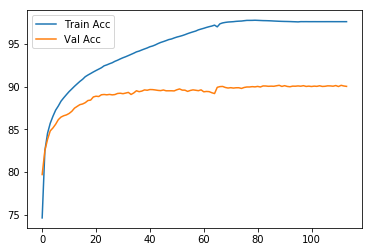

In [24]:
plt.plot(history212['acc'])
plt.plot(history212['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 90.139 epoch : 89 *


=====================================================

#### model 2 2 2

In [25]:
# model
torch.cuda.empty_cache()    
best_acc222 = 0
em_iters = [2,2,2]
model222 = capsules(A=A, B=B, C=C, D=D, E=num_class,in_channels=1
                    ,iters_routings=em_iters
                   ).to(device)
history222={'val_acc':[],'acc':[]}
optimizer222 = optim.Adam(model222.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 10, 3, 4, 1] 
iters for routings:  [2, 2, 2] 
stage output:  class_caps 
activation:  o


In [26]:
torch.cuda.empty_cache()
# model222.load_state_dict(torch.load('face_weights\\model_model222_A_55.pth'))
best_acc222= mainTrain('model222_A',epochs,model222,history222,optimizer222)

########### Training model model222_A ###########
Train Epoch: 1	[0/60000 (0%)]	Loss: 0.496700	Accuracy: 11.718750	
Train Epoch: 1	[6400/60000 (11%)]	Loss: 0.109168	Accuracy: 66.406250	
Train Epoch: 1	[12800/60000 (21%)]	Loss: 0.059938	Accuracy: 74.218750	
Train Epoch: 1	[19200/60000 (32%)]	Loss: 0.072549	Accuracy: 68.750000	
Train Epoch: 1	[25600/60000 (43%)]	Loss: 0.042316	Accuracy: 78.125000	
Train Epoch: 1	[32000/60000 (53%)]	Loss: 0.050421	Accuracy: 78.125000	
Train Epoch: 1	[38400/60000 (64%)]	Loss: 0.045350	Accuracy: 81.250000	
Train Epoch: 1	[44800/60000 (75%)]	Loss: 0.054989	Accuracy: 78.125000	
Train Epoch: 1	[51200/60000 (85%)]	Loss: 0.055953	Accuracy: 78.125000	
Train Epoch: 1	[57600/60000 (96%)]	Loss: 0.040776	Accuracy: 78.906250	
Epoch Train-loss : 0.0701, Epoch Train-accuracy : 72.9122
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.994116, Accuracy: 79.112477 


saving model to FMnist_weights\model_model222_A_1.pth
Current Learning Rate : 0.0009990

Train Epoch: 8	[6400/60000 (11%)]	Loss: 0.037681	Accuracy: 83.593750	
Train Epoch: 8	[12800/60000 (21%)]	Loss: 0.023188	Accuracy: 89.843750	
Train Epoch: 8	[19200/60000 (32%)]	Loss: 0.035733	Accuracy: 84.375000	
Train Epoch: 8	[25600/60000 (43%)]	Loss: 0.021833	Accuracy: 90.625000	
Train Epoch: 8	[32000/60000 (53%)]	Loss: 0.030177	Accuracy: 84.375000	
Train Epoch: 8	[38400/60000 (64%)]	Loss: 0.028364	Accuracy: 89.843750	
Train Epoch: 8	[44800/60000 (75%)]	Loss: 0.033976	Accuracy: 85.156250	
Train Epoch: 8	[51200/60000 (85%)]	Loss: 0.031647	Accuracy: 89.843750	
Train Epoch: 8	[57600/60000 (96%)]	Loss: 0.025075	Accuracy: 90.625000	
Epoch Train-loss : 0.0272, Epoch Train-accuracy : 88.0558
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.131497, Accuracy: 85.160271 


saving model to FMnist_weights\model_model222_A_8.pth
Current Learning Rate : 0.000992371043175416
* Best val Accuracy so far : 85.160 epoch : 8 *
Total 1 epochs with no improvement in val_acc.
Epoch tim

Train Epoch: 15	[12800/60000 (21%)]	Loss: 0.021374	Accuracy: 89.062500	
Train Epoch: 15	[19200/60000 (32%)]	Loss: 0.035893	Accuracy: 86.718750	
Train Epoch: 15	[25600/60000 (43%)]	Loss: 0.020805	Accuracy: 93.750000	
Train Epoch: 15	[32000/60000 (53%)]	Loss: 0.031576	Accuracy: 84.375000	
Train Epoch: 15	[38400/60000 (64%)]	Loss: 0.027365	Accuracy: 92.187500	
Train Epoch: 15	[44800/60000 (75%)]	Loss: 0.035779	Accuracy: 88.281250	
Train Epoch: 15	[51200/60000 (85%)]	Loss: 0.026183	Accuracy: 92.968750	
Train Epoch: 15	[57600/60000 (96%)]	Loss: 0.026553	Accuracy: 89.843750	
Epoch Train-loss : 0.0256, Epoch Train-accuracy : 90.4401
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.846280, Accuracy: 86.764131 


saving model to FMnist_weights\model_model222_A_15.pth
Current Learning Rate : 0.0009857434641560286
* Best val Accuracy so far : 86.764 epoch : 15 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 6.11 mins
Train Epoch: 16	[0/60000 (0%)]	Loss: 0.017266	

Train Epoch: 22	[12800/60000 (21%)]	Loss: 0.017473	Accuracy: 92.187500	
Train Epoch: 22	[19200/60000 (32%)]	Loss: 0.034090	Accuracy: 87.500000	
Train Epoch: 22	[25600/60000 (43%)]	Loss: 0.022587	Accuracy: 93.750000	
Train Epoch: 22	[32000/60000 (53%)]	Loss: 0.032654	Accuracy: 87.500000	
Train Epoch: 22	[38400/60000 (64%)]	Loss: 0.025449	Accuracy: 92.968750	
Train Epoch: 22	[44800/60000 (75%)]	Loss: 0.037496	Accuracy: 89.062500	
Train Epoch: 22	[51200/60000 (85%)]	Loss: 0.026983	Accuracy: 93.750000	
Train Epoch: 22	[57600/60000 (96%)]	Loss: 0.025719	Accuracy: 93.750000	
Epoch Train-loss : 0.0255, Epoch Train-accuracy : 92.0198
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.704267, Accuracy: 86.697495 


saving model to FMnist_weights\model_model222_A_22.pth
Current Learning Rate : 0.00097916014761685
* Best val Accuracy so far : 86.917 epoch : 21 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 6.10 mins
Train Epoch: 23	[0/60000 (0%)]	Loss: 0.015801	Ac

Train Epoch: 29	[12800/60000 (21%)]	Loss: 0.017390	Accuracy: 96.093750	
Train Epoch: 29	[19200/60000 (32%)]	Loss: 0.027019	Accuracy: 93.750000	
Train Epoch: 29	[25600/60000 (43%)]	Loss: 0.023514	Accuracy: 94.531250	
Train Epoch: 29	[32000/60000 (53%)]	Loss: 0.027843	Accuracy: 90.625000	
Train Epoch: 29	[38400/60000 (64%)]	Loss: 0.030179	Accuracy: 92.968750	
Train Epoch: 29	[44800/60000 (75%)]	Loss: 0.037827	Accuracy: 88.281250	
Train Epoch: 29	[51200/60000 (85%)]	Loss: 0.029134	Accuracy: 92.187500	
Train Epoch: 29	[57600/60000 (96%)]	Loss: 0.026829	Accuracy: 92.187500	
Epoch Train-loss : 0.0261, Epoch Train-accuracy : 93.1220
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.584125, Accuracy: 86.750344 


saving model to FMnist_weights\model_model222_A_29.pth
Current Learning Rate : 0.000972620797949612
* Best val Accuracy so far : 86.917 epoch : 21 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 6.11 mins
Train Epoch: 30	[0/60000 (0%)]	Loss: 0.015408	A

Train Epoch: 36	[12800/60000 (21%)]	Loss: 0.022457	Accuracy: 94.531250	
Train Epoch: 36	[19200/60000 (32%)]	Loss: 0.030458	Accuracy: 92.968750	
Train Epoch: 36	[25600/60000 (43%)]	Loss: 0.021597	Accuracy: 96.875000	
Train Epoch: 36	[32000/60000 (53%)]	Loss: 0.034462	Accuracy: 90.625000	
Train Epoch: 36	[38400/60000 (64%)]	Loss: 0.025914	Accuracy: 94.531250	
Train Epoch: 36	[44800/60000 (75%)]	Loss: 0.035249	Accuracy: 92.968750	
Train Epoch: 36	[51200/60000 (85%)]	Loss: 0.029401	Accuracy: 92.968750	
Train Epoch: 36	[57600/60000 (96%)]	Loss: 0.033959	Accuracy: 92.968750	
Epoch Train-loss : 0.0269, Epoch Train-accuracy : 94.2031
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.506543, Accuracy: 86.474035 


saving model to FMnist_weights\model_model222_A_36.pth
Current Learning Rate : 0.0009661251215202755
* Best val Accuracy so far : 87.066 epoch : 32 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 6.10 mins
Train Epoch: 37	[0/60000 (0%)]	Loss: 0.016281	

Train Epoch: 43	[12800/60000 (21%)]	Loss: 0.024653	Accuracy: 95.312500	
Train Epoch: 43	[19200/60000 (32%)]	Loss: 0.027787	Accuracy: 93.750000	
Train Epoch: 43	[25600/60000 (43%)]	Loss: 0.021446	Accuracy: 96.875000	
Train Epoch: 43	[32000/60000 (53%)]	Loss: 0.040663	Accuracy: 90.625000	
Train Epoch: 43	[38400/60000 (64%)]	Loss: 0.024259	Accuracy: 95.312500	
Train Epoch: 43	[44800/60000 (75%)]	Loss: 0.038180	Accuracy: 91.406250	
Train Epoch: 43	[51200/60000 (85%)]	Loss: 0.029891	Accuracy: 95.312500	
Train Epoch: 43	[57600/60000 (96%)]	Loss: 0.029285	Accuracy: 95.312500	
Epoch Train-loss : 0.0276, Epoch Train-accuracy : 94.9777
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.482873, Accuracy: 86.460248 


saving model to FMnist_weights\model_model222_A_43.pth
Current Learning Rate : 0.0009596728266558442
* Best val Accuracy so far : 87.066 epoch : 32 *
Total 11 epochs with no improvement in val_acc.
Epoch time: 6.12 mins
Train Epoch: 44	[0/60000 (0%)]	Loss: 0.013920

Train Epoch: 50	[6400/60000 (11%)]	Loss: 0.041698	Accuracy: 91.406250	
Train Epoch: 50	[12800/60000 (21%)]	Loss: 0.022474	Accuracy: 97.656250	
Train Epoch: 50	[19200/60000 (32%)]	Loss: 0.029042	Accuracy: 95.312500	
Train Epoch: 50	[25600/60000 (43%)]	Loss: 0.023593	Accuracy: 94.531250	
Train Epoch: 50	[32000/60000 (53%)]	Loss: 0.038089	Accuracy: 92.187500	
Train Epoch: 50	[38400/60000 (64%)]	Loss: 0.023813	Accuracy: 96.875000	
Train Epoch: 50	[44800/60000 (75%)]	Loss: 0.033939	Accuracy: 95.312500	
Train Epoch: 50	[51200/60000 (85%)]	Loss: 0.026211	Accuracy: 97.656250	
Train Epoch: 50	[57600/60000 (96%)]	Loss: 0.022971	Accuracy: 97.656250	
Epoch Train-loss : 0.0279, Epoch Train-accuracy : 95.8761
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.389644, Accuracy: 87.882582 


saving model to FMnist_weights\model_model222_A_50.pth
Current Learning Rate : 9.532636236312693e-05
* Best val Accuracy so far : 87.883 epoch : 50 *
Total 1 epochs with no improvement in val_ac

Train Epoch: 57	[6400/60000 (11%)]	Loss: 0.043005	Accuracy: 92.968750	
Train Epoch: 57	[12800/60000 (21%)]	Loss: 0.024401	Accuracy: 97.656250	
Train Epoch: 57	[19200/60000 (32%)]	Loss: 0.032613	Accuracy: 96.093750	
Train Epoch: 57	[25600/60000 (43%)]	Loss: 0.026161	Accuracy: 95.312500	
Train Epoch: 57	[32000/60000 (53%)]	Loss: 0.041684	Accuracy: 93.750000	
Train Epoch: 57	[38400/60000 (64%)]	Loss: 0.026459	Accuracy: 97.656250	
Train Epoch: 57	[44800/60000 (75%)]	Loss: 0.038843	Accuracy: 96.093750	
Train Epoch: 57	[51200/60000 (85%)]	Loss: 0.029405	Accuracy: 97.656250	
Train Epoch: 57	[57600/60000 (96%)]	Loss: 0.026852	Accuracy: 98.437500	
Epoch Train-loss : 0.0309, Epoch Train-accuracy : 96.3864
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.385898, Accuracy: 87.784352 


saving model to FMnist_weights\model_model222_A_57.pth
Current Learning Rate : 9.468972246564384e-05
6 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accur

Train Epoch: 64	[0/60000 (0%)]	Loss: 0.024221	Accuracy: 99.218750	
Train Epoch: 64	[6400/60000 (11%)]	Loss: 0.054086	Accuracy: 94.531250	
Train Epoch: 64	[12800/60000 (21%)]	Loss: 0.030789	Accuracy: 97.656250	
Train Epoch: 64	[19200/60000 (32%)]	Loss: 0.041936	Accuracy: 96.875000	
Train Epoch: 64	[25600/60000 (43%)]	Loss: 0.031938	Accuracy: 96.093750	
Train Epoch: 64	[32000/60000 (53%)]	Loss: 0.050598	Accuracy: 93.750000	
Train Epoch: 64	[38400/60000 (64%)]	Loss: 0.033488	Accuracy: 97.656250	
Train Epoch: 64	[44800/60000 (75%)]	Loss: 0.044635	Accuracy: 96.093750	
Train Epoch: 64	[51200/60000 (85%)]	Loss: 0.034537	Accuracy: 97.656250	
Train Epoch: 64	[57600/60000 (96%)]	Loss: 0.031101	Accuracy: 98.437500	
Epoch Train-loss : 0.0372, Epoch Train-accuracy : 96.6151
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.368566, Accuracy: 87.911879 


saving model to FMnist_weights\model_model222_A_64.pth
Current Learning Rate : 9.405733438632543e-06
* Best val Accuracy so far

Train Epoch: 71	[0/60000 (0%)]	Loss: 0.032241	Accuracy: 99.218750	
Train Epoch: 71	[6400/60000 (11%)]	Loss: 0.066919	Accuracy: 94.531250	
Train Epoch: 71	[12800/60000 (21%)]	Loss: 0.039130	Accuracy: 97.656250	
Train Epoch: 71	[19200/60000 (32%)]	Loss: 0.052496	Accuracy: 96.875000	
Train Epoch: 71	[25600/60000 (43%)]	Loss: 0.040331	Accuracy: 96.093750	
Train Epoch: 71	[32000/60000 (53%)]	Loss: 0.063156	Accuracy: 93.750000	
Train Epoch: 71	[38400/60000 (64%)]	Loss: 0.042466	Accuracy: 97.656250	
Train Epoch: 71	[44800/60000 (75%)]	Loss: 0.056943	Accuracy: 96.093750	
Train Epoch: 71	[51200/60000 (85%)]	Loss: 0.045051	Accuracy: 97.656250	
Train Epoch: 71	[57600/60000 (96%)]	Loss: 0.040623	Accuracy: 98.437500	
Epoch Train-loss : 0.0473, Epoch Train-accuracy : 96.6085
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.362755, Accuracy: 87.879710 


saving model to FMnist_weights\model_model222_A_71.pth
Current Learning Rate : 9.342916972927978e-06
* Best val Accuracy so far

Train Epoch: 78	[0/60000 (0%)]	Loss: 0.044485	Accuracy: 99.218750	
Train Epoch: 78	[6400/60000 (11%)]	Loss: 0.085807	Accuracy: 94.531250	
Train Epoch: 78	[12800/60000 (21%)]	Loss: 0.051876	Accuracy: 97.656250	
Train Epoch: 78	[19200/60000 (32%)]	Loss: 0.068454	Accuracy: 96.875000	
Train Epoch: 78	[25600/60000 (43%)]	Loss: 0.053636	Accuracy: 96.093750	
Train Epoch: 78	[32000/60000 (53%)]	Loss: 0.079973	Accuracy: 93.750000	
Train Epoch: 78	[38400/60000 (64%)]	Loss: 0.056070	Accuracy: 97.656250	
Train Epoch: 78	[44800/60000 (75%)]	Loss: 0.072924	Accuracy: 96.093750	
Train Epoch: 78	[51200/60000 (85%)]	Loss: 0.059286	Accuracy: 97.656250	
Train Epoch: 78	[57600/60000 (96%)]	Loss: 0.054273	Accuracy: 98.437500	
Epoch Train-loss : 0.0618, Epoch Train-accuracy : 96.6618
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.357608, Accuracy: 87.877412 


saving model to FMnist_weights\model_model222_A_78.pth
Current Learning Rate : 9.280520028825781e-07
* Best val Accuracy so far

Train Epoch: 85	[0/60000 (0%)]	Loss: 0.064837	Accuracy: 99.218750	
Train Epoch: 85	[6400/60000 (11%)]	Loss: 0.112250	Accuracy: 94.531250	
Train Epoch: 85	[12800/60000 (21%)]	Loss: 0.071843	Accuracy: 97.656250	
Train Epoch: 85	[19200/60000 (32%)]	Loss: 0.092611	Accuracy: 96.875000	
Train Epoch: 85	[25600/60000 (43%)]	Loss: 0.075115	Accuracy: 96.093750	
Train Epoch: 85	[32000/60000 (53%)]	Loss: 0.105438	Accuracy: 93.750000	
Train Epoch: 85	[38400/60000 (64%)]	Loss: 0.078510	Accuracy: 97.656250	
Train Epoch: 85	[44800/60000 (75%)]	Loss: 0.098168	Accuracy: 96.093750	
Train Epoch: 85	[51200/60000 (85%)]	Loss: 0.082333	Accuracy: 97.656250	
Train Epoch: 85	[57600/60000 (96%)]	Loss: 0.076814	Accuracy: 98.437500	
Epoch Train-loss : 0.0849, Epoch Train-accuracy : 96.6435
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.354820, Accuracy: 87.853860 


saving model to FMnist_weights\model_model222_A_85.pth
Current Learning Rate : 9.218539804538666e-07
* Best val Accuracy so far

Train Epoch: 92	[0/60000 (0%)]	Loss: 0.095812	Accuracy: 99.218750	
Train Epoch: 92	[6400/60000 (11%)]	Loss: 0.149469	Accuracy: 94.531250	
Train Epoch: 92	[12800/60000 (21%)]	Loss: 0.102394	Accuracy: 97.656250	
Train Epoch: 92	[19200/60000 (32%)]	Loss: 0.127442	Accuracy: 96.875000	
Train Epoch: 92	[25600/60000 (43%)]	Loss: 0.107200	Accuracy: 96.093750	
Train Epoch: 92	[32000/60000 (53%)]	Loss: 0.141354	Accuracy: 93.750000	
Train Epoch: 92	[38400/60000 (64%)]	Loss: 0.111582	Accuracy: 97.656250	
Train Epoch: 92	[44800/60000 (75%)]	Loss: 0.133738	Accuracy: 96.093750	
Train Epoch: 92	[51200/60000 (85%)]	Loss: 0.115687	Accuracy: 97.656250	
Train Epoch: 92	[57600/60000 (96%)]	Loss: 0.110099	Accuracy: 98.437500	
Epoch Train-loss : 0.1185, Epoch Train-accuracy : 96.6268
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.353495, Accuracy: 87.847541 


saving model to FMnist_weights\model_model222_A_92.pth
Current Learning Rate : 9.156973516991168e-08
* Best val Accuracy so far

Train Epoch: 99	[0/60000 (0%)]	Loss: 0.137823	Accuracy: 99.218750	
Train Epoch: 99	[6400/60000 (11%)]	Loss: 0.197462	Accuracy: 94.531250	
Train Epoch: 99	[12800/60000 (21%)]	Loss: 0.143798	Accuracy: 97.656250	
Train Epoch: 99	[19200/60000 (32%)]	Loss: 0.173175	Accuracy: 96.875000	
Train Epoch: 99	[25600/60000 (43%)]	Loss: 0.150281	Accuracy: 96.093750	
Train Epoch: 99	[32000/60000 (53%)]	Loss: 0.188002	Accuracy: 93.750000	
Train Epoch: 99	[38400/60000 (64%)]	Loss: 0.155690	Accuracy: 98.437500	
Train Epoch: 99	[44800/60000 (75%)]	Loss: 0.180109	Accuracy: 96.093750	
Train Epoch: 99	[51200/60000 (85%)]	Loss: 0.160092	Accuracy: 97.656250	
Train Epoch: 99	[57600/60000 (96%)]	Loss: 0.154390	Accuracy: 98.437500	
Epoch Train-loss : 0.1631, Epoch Train-accuracy : 96.6268
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.351397, Accuracy: 87.925092 


saving model to FMnist_weights\model_model222_A_99.pth
Current Learning Rate : 9.095818401694674e-09
* Best val Accuracy so far

Train Epoch: 106	[0/60000 (0%)]	Loss: 0.190692	Accuracy: 99.218750	
Train Epoch: 106	[6400/60000 (11%)]	Loss: 0.256257	Accuracy: 94.531250	
Train Epoch: 106	[12800/60000 (21%)]	Loss: 0.196026	Accuracy: 97.656250	
Train Epoch: 106	[19200/60000 (32%)]	Loss: 0.229744	Accuracy: 96.875000	
Train Epoch: 106	[25600/60000 (43%)]	Loss: 0.204217	Accuracy: 96.093750	
Train Epoch: 106	[32000/60000 (53%)]	Loss: 0.245438	Accuracy: 93.750000	
Train Epoch: 106	[38400/60000 (64%)]	Loss: 0.210658	Accuracy: 98.437500	
Train Epoch: 106	[44800/60000 (75%)]	Loss: 0.237278	Accuracy: 96.093750	
Train Epoch: 106	[51200/60000 (85%)]	Loss: 0.215354	Accuracy: 97.656250	
Train Epoch: 106	[57600/60000 (96%)]	Loss: 0.209534	Accuracy: 98.437500	
Epoch Train-loss : 0.2185, Epoch Train-accuracy : 96.6285
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.351996, Accuracy: 87.899242 


saving model to FMnist_weights\model_model222_A_106.pth
Current Learning Rate : 9.03507171262328e-10
* Best val Accur

Train Epoch: 113	[0/60000 (0%)]	Loss: 0.254368	Accuracy: 99.218750	
Train Epoch: 113	[6400/60000 (11%)]	Loss: 0.325855	Accuracy: 94.531250	
Train Epoch: 113	[12800/60000 (21%)]	Loss: 0.259060	Accuracy: 97.656250	
Train Epoch: 113	[19200/60000 (32%)]	Loss: 0.297119	Accuracy: 96.875000	
Train Epoch: 113	[25600/60000 (43%)]	Loss: 0.268961	Accuracy: 96.093750	
Train Epoch: 113	[32000/60000 (53%)]	Loss: 0.313678	Accuracy: 93.750000	
Train Epoch: 113	[38400/60000 (64%)]	Loss: 0.276434	Accuracy: 98.437500	
Train Epoch: 113	[44800/60000 (75%)]	Loss: 0.305250	Accuracy: 96.093750	
Train Epoch: 113	[51200/60000 (85%)]	Loss: 0.281424	Accuracy: 97.656250	
Train Epoch: 113	[57600/60000 (96%)]	Loss: 0.275484	Accuracy: 98.437500	
Epoch Train-loss : 0.2847, Epoch Train-accuracy : 96.6285
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.353428, Accuracy: 87.830308 


saving model to FMnist_weights\model_model222_A_113.pth
Current Learning Rate : 8.974730722090513e-11
* Best val Accu

Train Epoch: 120	[0/60000 (0%)]	Loss: 0.328848	Accuracy: 99.218750	
Train Epoch: 120	[6400/60000 (11%)]	Loss: 0.406259	Accuracy: 94.531250	
Train Epoch: 120	[12800/60000 (21%)]	Loss: 0.332898	Accuracy: 97.656250	
Train Epoch: 120	[19200/60000 (32%)]	Loss: 0.375300	Accuracy: 96.875000	
Train Epoch: 120	[25600/60000 (43%)]	Loss: 0.344509	Accuracy: 96.093750	
Train Epoch: 120	[32000/60000 (53%)]	Loss: 0.392721	Accuracy: 93.750000	
Train Epoch: 120	[38400/60000 (64%)]	Loss: 0.353014	Accuracy: 98.437500	
Train Epoch: 120	[44800/60000 (75%)]	Loss: 0.384026	Accuracy: 96.093750	
Train Epoch: 120	[51200/60000 (85%)]	Loss: 0.358299	Accuracy: 97.656250	
Train Epoch: 120	[57600/60000 (96%)]	Loss: 0.352240	Accuracy: 98.437500	
Epoch Train-loss : 0.3617, Epoch Train-accuracy : 96.6285
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.352594, Accuracy: 87.933709 


saving model to FMnist_weights\model_model222_A_120.pth
Current Learning Rate : 8.914792720626815e-12
* Best val Accu

Train Epoch: 127	[0/60000 (0%)]	Loss: 0.414133	Accuracy: 99.218750	
Train Epoch: 127	[6400/60000 (11%)]	Loss: 0.497466	Accuracy: 94.531250	
Train Epoch: 127	[12800/60000 (21%)]	Loss: 0.417542	Accuracy: 97.656250	
Train Epoch: 127	[19200/60000 (32%)]	Loss: 0.464284	Accuracy: 96.875000	
Train Epoch: 127	[25600/60000 (43%)]	Loss: 0.430863	Accuracy: 96.093750	
Train Epoch: 127	[32000/60000 (53%)]	Loss: 0.482569	Accuracy: 93.750000	
Train Epoch: 127	[38400/60000 (64%)]	Loss: 0.440399	Accuracy: 98.437500	
Train Epoch: 127	[44800/60000 (75%)]	Loss: 0.473607	Accuracy: 96.093750	
Train Epoch: 127	[51200/60000 (85%)]	Loss: 0.445978	Accuracy: 97.656250	
Train Epoch: 127	[57600/60000 (96%)]	Loss: 0.439799	Accuracy: 98.437500	
Epoch Train-loss : 0.4495, Epoch Train-accuracy : 96.6285
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.348307, Accuracy: 87.994026 


saving model to FMnist_weights\model_model222_A_127.pth
Current Learning Rate : 8.855255016857914e-13
* Best val Accu

Train Epoch: 134	[0/60000 (0%)]	Loss: 0.510223	Accuracy: 99.218750	
Train Epoch: 134	[6400/60000 (11%)]	Loss: 0.599478	Accuracy: 94.531250	
Train Epoch: 134	[12800/60000 (21%)]	Loss: 0.512989	Accuracy: 97.656250	
Train Epoch: 134	[19200/60000 (32%)]	Loss: 0.564074	Accuracy: 96.875000	
Train Epoch: 134	[25600/60000 (43%)]	Loss: 0.528020	Accuracy: 96.093750	
Train Epoch: 134	[32000/60000 (53%)]	Loss: 0.583221	Accuracy: 93.750000	
Train Epoch: 134	[38400/60000 (64%)]	Loss: 0.538588	Accuracy: 98.437500	
Train Epoch: 134	[44800/60000 (75%)]	Loss: 0.573993	Accuracy: 96.093750	
Train Epoch: 134	[51200/60000 (85%)]	Loss: 0.544462	Accuracy: 97.656250	
Train Epoch: 134	[57600/60000 (96%)]	Loss: 0.538163	Accuracy: 98.437500	
Epoch Train-loss : 0.5481, Epoch Train-accuracy : 96.6285
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.351414, Accuracy: 87.976792 


saving model to FMnist_weights\model_model222_A_134.pth
Current Learning Rate : 8.796114937383951e-13
6 epochs with n

Train Epoch: 141	[0/60000 (0%)]	Loss: 0.617117	Accuracy: 99.218750	
Train Epoch: 141	[6400/60000 (11%)]	Loss: 0.712295	Accuracy: 94.531250	
Train Epoch: 141	[12800/60000 (21%)]	Loss: 0.619241	Accuracy: 97.656250	
Train Epoch: 141	[19200/60000 (32%)]	Loss: 0.674667	Accuracy: 96.875000	
Train Epoch: 141	[25600/60000 (43%)]	Loss: 0.635982	Accuracy: 96.093750	
Train Epoch: 141	[32000/60000 (53%)]	Loss: 0.694678	Accuracy: 93.750000	
Train Epoch: 141	[38400/60000 (64%)]	Loss: 0.647582	Accuracy: 98.437500	
Train Epoch: 141	[44800/60000 (75%)]	Loss: 0.685183	Accuracy: 96.093750	
Train Epoch: 141	[51200/60000 (85%)]	Loss: 0.653750	Accuracy: 97.656250	
Train Epoch: 141	[57600/60000 (96%)]	Loss: 0.647331	Accuracy: 98.437500	
Epoch Train-loss : 0.6575, Epoch Train-accuracy : 96.6285
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.351829, Accuracy: 87.882008 


saving model to FMnist_weights\model_model222_A_141.pth
Current Learning Rate : 8.737369826659452e-14
6 epochs with n

Train Epoch: 148	[0/60000 (0%)]	Loss: 0.734816	Accuracy: 99.218750	
Train Epoch: 148	[6400/60000 (11%)]	Loss: 0.835916	Accuracy: 94.531250	
Train Epoch: 148	[12800/60000 (21%)]	Loss: 0.736297	Accuracy: 97.656250	
Train Epoch: 148	[19200/60000 (32%)]	Loss: 0.796065	Accuracy: 96.875000	
Train Epoch: 148	[25600/60000 (43%)]	Loss: 0.754749	Accuracy: 96.093750	
Train Epoch: 148	[32000/60000 (53%)]	Loss: 0.816940	Accuracy: 93.750000	
Train Epoch: 148	[38400/60000 (64%)]	Loss: 0.767380	Accuracy: 98.437500	
Train Epoch: 148	[44800/60000 (75%)]	Loss: 0.807177	Accuracy: 96.093750	
Train Epoch: 148	[51200/60000 (85%)]	Loss: 0.773843	Accuracy: 97.656250	
Train Epoch: 148	[57600/60000 (96%)]	Loss: 0.767305	Accuracy: 98.437500	
Epoch Train-loss : 0.7777, Epoch Train-accuracy : 96.6285
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.348787, Accuracy: 87.959559 


saving model to FMnist_weights\model_model222_A_148.pth
Current Learning Rate : 8.67901704687408e-15
6 epochs with no

In [27]:
print('best test accuracy: {:.6f}'.format(best_acc222))
with open('model222_A_history.pkl','wb') as f:
    pickle.dump(history222,f)

best test accuracy: 87.994026


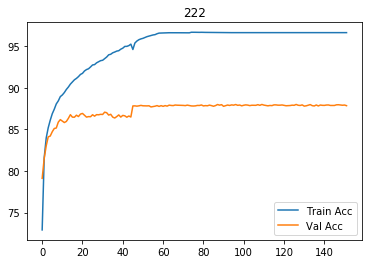

In [28]:
plt.title('222')
plt.plot(history222['acc'])
plt.plot(history222['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 87.994 epoch : 127 *

======================================================


#### model 112

In [29]:
# model
torch.cuda.empty_cache()
best_acc112 = 0
em_iters = [1,1,2]
model112 = capsules(A=A, B=B, C=C, D=D, E=num_class,in_channels=1,
                 iters_routings=em_iters).to(device)
history112={'val_acc':[],'acc':[]}
optimizer112 = optim.Adam(model112.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 10, 3, 4, 1] 
iters for routings:  [1, 1, 2] 
stage output:  class_caps 
activation:  o


In [30]:
torch.cuda.empty_cache()

best_acc112= mainTrain('model112_A',epochs,model112,history112,optimizer112)


########### Training model model112_A ###########
Train Epoch: 1	[0/60000 (0%)]	Loss: 0.558716	Accuracy: 9.375000	
Train Epoch: 1	[6400/60000 (11%)]	Loss: 0.084411	Accuracy: 64.843750	
Train Epoch: 1	[12800/60000 (21%)]	Loss: 0.049906	Accuracy: 76.562500	
Train Epoch: 1	[19200/60000 (32%)]	Loss: 0.066874	Accuracy: 68.750000	
Train Epoch: 1	[25600/60000 (43%)]	Loss: 0.040001	Accuracy: 79.687500	
Train Epoch: 1	[32000/60000 (53%)]	Loss: 0.048151	Accuracy: 79.687500	
Train Epoch: 1	[38400/60000 (64%)]	Loss: 0.042356	Accuracy: 79.687500	
Train Epoch: 1	[44800/60000 (75%)]	Loss: 0.041705	Accuracy: 79.687500	
Train Epoch: 1	[51200/60000 (85%)]	Loss: 0.042180	Accuracy: 83.593750	
Train Epoch: 1	[57600/60000 (96%)]	Loss: 0.035201	Accuracy: 81.250000	
Epoch Train-loss : 0.0617, Epoch Train-accuracy : 74.3803
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.985110, Accuracy: 79.214729 


saving model to FMnist_weights\model_model112_A_1.pth
Current Learning Rate : 0.00099904

Train Epoch: 8	[6400/60000 (11%)]	Loss: 0.039151	Accuracy: 84.375000	
Train Epoch: 8	[12800/60000 (21%)]	Loss: 0.024389	Accuracy: 87.500000	
Train Epoch: 8	[19200/60000 (32%)]	Loss: 0.032489	Accuracy: 88.281250	
Train Epoch: 8	[25600/60000 (43%)]	Loss: 0.019040	Accuracy: 91.406250	
Train Epoch: 8	[32000/60000 (53%)]	Loss: 0.032153	Accuracy: 85.156250	
Train Epoch: 8	[38400/60000 (64%)]	Loss: 0.027994	Accuracy: 90.625000	
Train Epoch: 8	[44800/60000 (75%)]	Loss: 0.034452	Accuracy: 85.156250	
Train Epoch: 8	[51200/60000 (85%)]	Loss: 0.032300	Accuracy: 89.843750	
Train Epoch: 8	[57600/60000 (96%)]	Loss: 0.026607	Accuracy: 86.718750	
Epoch Train-loss : 0.0280, Epoch Train-accuracy : 87.9509
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.372127, Accuracy: 86.054688 


saving model to FMnist_weights\model_model112_A_8.pth
Current Learning Rate : 0.000992371043175416
* Best val Accuracy so far : 86.055 epoch : 8 *
Total 1 epochs with no improvement in val_acc.
Epoch tim

Train Epoch: 15	[12800/60000 (21%)]	Loss: 0.022504	Accuracy: 88.281250	
Train Epoch: 15	[19200/60000 (32%)]	Loss: 0.034111	Accuracy: 87.500000	
Train Epoch: 15	[25600/60000 (43%)]	Loss: 0.020064	Accuracy: 92.968750	
Train Epoch: 15	[32000/60000 (53%)]	Loss: 0.033421	Accuracy: 86.718750	
Train Epoch: 15	[38400/60000 (64%)]	Loss: 0.026958	Accuracy: 90.625000	
Train Epoch: 15	[44800/60000 (75%)]	Loss: 0.036853	Accuracy: 88.281250	
Train Epoch: 15	[51200/60000 (85%)]	Loss: 0.033049	Accuracy: 92.187500	
Train Epoch: 15	[57600/60000 (96%)]	Loss: 0.029792	Accuracy: 86.718750	
Epoch Train-loss : 0.0281, Epoch Train-accuracy : 89.9293
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.105893, Accuracy: 87.196691 


saving model to FMnist_weights\model_model112_A_15.pth
Current Learning Rate : 0.0009857434641560286
* Best val Accuracy so far : 87.324 epoch : 14 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 4.69 mins
Train Epoch: 16	[0/60000 (0%)]	Loss: 0.018153	

Train Epoch: 22	[12800/60000 (21%)]	Loss: 0.021792	Accuracy: 92.187500	
Train Epoch: 22	[19200/60000 (32%)]	Loss: 0.036578	Accuracy: 88.281250	
Train Epoch: 22	[25600/60000 (43%)]	Loss: 0.022372	Accuracy: 93.750000	
Train Epoch: 22	[32000/60000 (53%)]	Loss: 0.036647	Accuracy: 86.718750	
Train Epoch: 22	[38400/60000 (64%)]	Loss: 0.028816	Accuracy: 91.406250	
Train Epoch: 22	[44800/60000 (75%)]	Loss: 0.040883	Accuracy: 88.281250	
Train Epoch: 22	[51200/60000 (85%)]	Loss: 0.034558	Accuracy: 93.750000	
Train Epoch: 22	[57600/60000 (96%)]	Loss: 0.032427	Accuracy: 89.062500	
Epoch Train-loss : 0.0300, Epoch Train-accuracy : 90.9387
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.903914, Accuracy: 87.949219 


saving model to FMnist_weights\model_model112_A_22.pth
Current Learning Rate : 0.00097916014761685
* Best val Accuracy so far : 87.990 epoch : 21 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 4.70 mins
Train Epoch: 23	[0/60000 (0%)]	Loss: 0.019275	Ac

Train Epoch: 29	[12800/60000 (21%)]	Loss: 0.023489	Accuracy: 91.406250	
Train Epoch: 29	[19200/60000 (32%)]	Loss: 0.039581	Accuracy: 89.062500	
Train Epoch: 29	[25600/60000 (43%)]	Loss: 0.024637	Accuracy: 93.750000	
Train Epoch: 29	[32000/60000 (53%)]	Loss: 0.041653	Accuracy: 88.281250	
Train Epoch: 29	[38400/60000 (64%)]	Loss: 0.031254	Accuracy: 92.187500	
Train Epoch: 29	[44800/60000 (75%)]	Loss: 0.046922	Accuracy: 89.062500	
Train Epoch: 29	[51200/60000 (85%)]	Loss: 0.035901	Accuracy: 93.750000	
Train Epoch: 29	[57600/60000 (96%)]	Loss: 0.035313	Accuracy: 91.406250	
Epoch Train-loss : 0.0327, Epoch Train-accuracy : 91.7405
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.752206, Accuracy: 88.453010 


saving model to FMnist_weights\model_model112_A_29.pth
Current Learning Rate : 0.000972620797949612
* Best val Accuracy so far : 88.510 epoch : 28 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 4.62 mins
Train Epoch: 30	[0/60000 (0%)]	Loss: 0.021729	A

Train Epoch: 36	[12800/60000 (21%)]	Loss: 0.024535	Accuracy: 93.750000	
Train Epoch: 36	[19200/60000 (32%)]	Loss: 0.043618	Accuracy: 91.406250	
Train Epoch: 36	[25600/60000 (43%)]	Loss: 0.027395	Accuracy: 92.968750	
Train Epoch: 36	[32000/60000 (53%)]	Loss: 0.044866	Accuracy: 89.062500	
Train Epoch: 36	[38400/60000 (64%)]	Loss: 0.036486	Accuracy: 93.750000	
Train Epoch: 36	[44800/60000 (75%)]	Loss: 0.053487	Accuracy: 89.062500	
Train Epoch: 36	[51200/60000 (85%)]	Loss: 0.038999	Accuracy: 94.531250	
Train Epoch: 36	[57600/60000 (96%)]	Loss: 0.041161	Accuracy: 92.187500	
Epoch Train-loss : 0.0359, Epoch Train-accuracy : 92.3635
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.631449, Accuracy: 89.137753 


saving model to FMnist_weights\model_model112_A_36.pth
Current Learning Rate : 0.0009661251215202755
* Best val Accuracy so far : 89.138 epoch : 36 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 4.70 mins
Train Epoch: 37	[0/60000 (0%)]	Loss: 0.023182	

Train Epoch: 43	[12800/60000 (21%)]	Loss: 0.027343	Accuracy: 95.312500	
Train Epoch: 43	[19200/60000 (32%)]	Loss: 0.047108	Accuracy: 92.187500	
Train Epoch: 43	[25600/60000 (43%)]	Loss: 0.029163	Accuracy: 92.187500	
Train Epoch: 43	[32000/60000 (53%)]	Loss: 0.049858	Accuracy: 89.843750	
Train Epoch: 43	[38400/60000 (64%)]	Loss: 0.041911	Accuracy: 93.750000	
Train Epoch: 43	[44800/60000 (75%)]	Loss: 0.061763	Accuracy: 89.843750	
Train Epoch: 43	[51200/60000 (85%)]	Loss: 0.042083	Accuracy: 95.312500	
Train Epoch: 43	[57600/60000 (96%)]	Loss: 0.045577	Accuracy: 92.968750	
Epoch Train-loss : 0.0395, Epoch Train-accuracy : 92.8305
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.536375, Accuracy: 89.404297 


saving model to FMnist_weights\model_model112_A_43.pth
Current Learning Rate : 0.0009596728266558442
* Best val Accuracy so far : 89.404 epoch : 43 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 4.69 mins
Train Epoch: 44	[0/60000 (0%)]	Loss: 0.024982	

Train Epoch: 50	[12800/60000 (21%)]	Loss: 0.030900	Accuracy: 95.312500	
Train Epoch: 50	[19200/60000 (32%)]	Loss: 0.050444	Accuracy: 92.187500	
Train Epoch: 50	[25600/60000 (43%)]	Loss: 0.032428	Accuracy: 92.968750	
Train Epoch: 50	[32000/60000 (53%)]	Loss: 0.056759	Accuracy: 89.843750	
Train Epoch: 50	[38400/60000 (64%)]	Loss: 0.046785	Accuracy: 94.531250	
Train Epoch: 50	[44800/60000 (75%)]	Loss: 0.069511	Accuracy: 90.625000	
Train Epoch: 50	[51200/60000 (85%)]	Loss: 0.046767	Accuracy: 96.093750	
Train Epoch: 50	[57600/60000 (96%)]	Loss: 0.048929	Accuracy: 92.968750	
Epoch Train-loss : 0.0434, Epoch Train-accuracy : 93.3158
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.440518, Accuracy: 89.712776 


saving model to FMnist_weights\model_model112_A_50.pth
Current Learning Rate : 0.0009532636236312693
* Best val Accuracy so far : 89.713 epoch : 50 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 4.69 mins
Train Epoch: 51	[0/60000 (0%)]	Loss: 0.027112	

Train Epoch: 57	[12800/60000 (21%)]	Loss: 0.033434	Accuracy: 96.093750	
Train Epoch: 57	[19200/60000 (32%)]	Loss: 0.053054	Accuracy: 92.187500	
Train Epoch: 57	[25600/60000 (43%)]	Loss: 0.037770	Accuracy: 92.968750	
Train Epoch: 57	[32000/60000 (53%)]	Loss: 0.065543	Accuracy: 91.406250	
Train Epoch: 57	[38400/60000 (64%)]	Loss: 0.052676	Accuracy: 93.750000	
Train Epoch: 57	[44800/60000 (75%)]	Loss: 0.075046	Accuracy: 89.843750	
Train Epoch: 57	[51200/60000 (85%)]	Loss: 0.051228	Accuracy: 96.875000	
Train Epoch: 57	[57600/60000 (96%)]	Loss: 0.052023	Accuracy: 92.968750	
Epoch Train-loss : 0.0475, Epoch Train-accuracy : 93.8094
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.371624, Accuracy: 89.743221 


saving model to FMnist_weights\model_model112_A_57.pth
Current Learning Rate : 0.0009468972246564383
* Best val Accuracy so far : 89.743 epoch : 57 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 4.71 mins
Train Epoch: 58	[0/60000 (0%)]	Loss: 0.028032	

Train Epoch: 64	[12800/60000 (21%)]	Loss: 0.037247	Accuracy: 96.093750	
Train Epoch: 64	[19200/60000 (32%)]	Loss: 0.057239	Accuracy: 92.968750	
Train Epoch: 64	[25600/60000 (43%)]	Loss: 0.040831	Accuracy: 92.968750	
Train Epoch: 64	[32000/60000 (53%)]	Loss: 0.075670	Accuracy: 91.406250	
Train Epoch: 64	[38400/60000 (64%)]	Loss: 0.059464	Accuracy: 92.968750	
Train Epoch: 64	[44800/60000 (75%)]	Loss: 0.080876	Accuracy: 91.406250	
Train Epoch: 64	[51200/60000 (85%)]	Loss: 0.054290	Accuracy: 96.093750	
Train Epoch: 64	[57600/60000 (96%)]	Loss: 0.056772	Accuracy: 96.093750	
Epoch Train-loss : 0.0520, Epoch Train-accuracy : 94.2525
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.300753, Accuracy: 89.763902 


saving model to FMnist_weights\model_model112_A_64.pth
Current Learning Rate : 0.0009405733438632542
* Best val Accuracy so far : 89.764 epoch : 64 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 4.69 mins
Train Epoch: 65	[0/60000 (0%)]	Loss: 0.031395	

Train Epoch: 71	[12800/60000 (21%)]	Loss: 0.038952	Accuracy: 95.312500	
Train Epoch: 71	[19200/60000 (32%)]	Loss: 0.063875	Accuracy: 92.968750	
Train Epoch: 71	[25600/60000 (43%)]	Loss: 0.045987	Accuracy: 92.968750	
Train Epoch: 71	[32000/60000 (53%)]	Loss: 0.083691	Accuracy: 91.406250	
Train Epoch: 71	[38400/60000 (64%)]	Loss: 0.065659	Accuracy: 92.968750	
Train Epoch: 71	[44800/60000 (75%)]	Loss: 0.089354	Accuracy: 93.750000	
Train Epoch: 71	[51200/60000 (85%)]	Loss: 0.061985	Accuracy: 96.093750	
Train Epoch: 71	[57600/60000 (96%)]	Loss: 0.060948	Accuracy: 94.531250	
Epoch Train-loss : 0.0578, Epoch Train-accuracy : 94.6073
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.235847, Accuracy: 89.685202 


saving model to FMnist_weights\model_model112_A_71.pth
Current Learning Rate : 0.0009342916972927977
* Best val Accuracy so far : 89.960 epoch : 66 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 4.70 mins
Train Epoch: 72	[0/60000 (0%)]	Loss: 0.034594	

Train Epoch: 78	[12800/60000 (21%)]	Loss: 0.045039	Accuracy: 97.656250	
Train Epoch: 78	[19200/60000 (32%)]	Loss: 0.073098	Accuracy: 93.750000	
Train Epoch: 78	[25600/60000 (43%)]	Loss: 0.051793	Accuracy: 93.750000	
Train Epoch: 78	[32000/60000 (53%)]	Loss: 0.093648	Accuracy: 91.406250	
Train Epoch: 78	[38400/60000 (64%)]	Loss: 0.071546	Accuracy: 92.968750	
Train Epoch: 78	[44800/60000 (75%)]	Loss: 0.095452	Accuracy: 92.968750	
Train Epoch: 78	[51200/60000 (85%)]	Loss: 0.072239	Accuracy: 93.750000	
Train Epoch: 78	[57600/60000 (96%)]	Loss: 0.069070	Accuracy: 94.531250	
Epoch Train-loss : 0.0654, Epoch Train-accuracy : 94.9793
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.183424, Accuracy: 89.619715 


saving model to FMnist_weights\model_model112_A_78.pth
Current Learning Rate : 0.0009280520028825778
* Best val Accuracy so far : 89.960 epoch : 66 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 4.69 mins
Train Epoch: 79	[0/60000 (0%)]	Loss: 0.040837

Train Epoch: 85	[6400/60000 (11%)]	Loss: 0.096871	Accuracy: 96.093750	
Train Epoch: 85	[12800/60000 (21%)]	Loss: 0.054060	Accuracy: 97.656250	
Train Epoch: 85	[19200/60000 (32%)]	Loss: 0.086820	Accuracy: 96.093750	
Train Epoch: 85	[25600/60000 (43%)]	Loss: 0.063686	Accuracy: 95.312500	
Train Epoch: 85	[32000/60000 (53%)]	Loss: 0.108420	Accuracy: 90.625000	
Train Epoch: 85	[38400/60000 (64%)]	Loss: 0.077358	Accuracy: 94.531250	
Train Epoch: 85	[44800/60000 (75%)]	Loss: 0.098610	Accuracy: 93.750000	
Train Epoch: 85	[51200/60000 (85%)]	Loss: 0.080506	Accuracy: 96.875000	
Train Epoch: 85	[57600/60000 (96%)]	Loss: 0.071741	Accuracy: 97.656250	
Epoch Train-loss : 0.0762, Epoch Train-accuracy : 95.5241
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.130497, Accuracy: 90.546301 


saving model to FMnist_weights\model_model112_A_85.pth
Current Learning Rate : 9.218539804538664e-05
* Best val Accuracy so far : 90.631 epoch : 81 *
Total 4 epochs with no improvement in val_ac

Train Epoch: 92	[0/60000 (0%)]	Loss: 0.075497	Accuracy: 97.656250	
Train Epoch: 92	[6400/60000 (11%)]	Loss: 0.126571	Accuracy: 96.875000	
Train Epoch: 92	[12800/60000 (21%)]	Loss: 0.077264	Accuracy: 97.656250	
Train Epoch: 92	[19200/60000 (32%)]	Loss: 0.118201	Accuracy: 96.093750	
Train Epoch: 92	[25600/60000 (43%)]	Loss: 0.086856	Accuracy: 95.312500	
Train Epoch: 92	[32000/60000 (53%)]	Loss: 0.143127	Accuracy: 91.406250	
Train Epoch: 92	[38400/60000 (64%)]	Loss: 0.103099	Accuracy: 95.312500	
Train Epoch: 92	[44800/60000 (75%)]	Loss: 0.126847	Accuracy: 92.968750	
Train Epoch: 92	[51200/60000 (85%)]	Loss: 0.109030	Accuracy: 96.093750	
Train Epoch: 92	[57600/60000 (96%)]	Loss: 0.098268	Accuracy: 97.656250	
Epoch Train-loss : 0.1018, Epoch Train-accuracy : 95.6529
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.115954, Accuracy: 90.427390 


saving model to FMnist_weights\model_model112_A_92.pth
Current Learning Rate : 9.156973516991167e-06
* Best val Accuracy so far

Train Epoch: 99	[0/60000 (0%)]	Loss: 0.110431	Accuracy: 97.656250	
Train Epoch: 99	[6400/60000 (11%)]	Loss: 0.167172	Accuracy: 96.875000	
Train Epoch: 99	[12800/60000 (21%)]	Loss: 0.111824	Accuracy: 97.656250	
Train Epoch: 99	[19200/60000 (32%)]	Loss: 0.157947	Accuracy: 96.093750	
Train Epoch: 99	[25600/60000 (43%)]	Loss: 0.122210	Accuracy: 94.531250	
Train Epoch: 99	[32000/60000 (53%)]	Loss: 0.185522	Accuracy: 91.406250	
Train Epoch: 99	[38400/60000 (64%)]	Loss: 0.142088	Accuracy: 95.312500	
Train Epoch: 99	[44800/60000 (75%)]	Loss: 0.168576	Accuracy: 93.750000	
Train Epoch: 99	[51200/60000 (85%)]	Loss: 0.148657	Accuracy: 96.093750	
Train Epoch: 99	[57600/60000 (96%)]	Loss: 0.136412	Accuracy: 97.656250	
Epoch Train-loss : 0.1398, Epoch Train-accuracy : 95.6373
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.113778, Accuracy: 90.351562 


saving model to FMnist_weights\model_model112_A_99.pth
Current Learning Rate : 9.095818401694672e-07
* Best val Accuracy so far

Train Epoch: 106	[0/60000 (0%)]	Loss: 0.156331	Accuracy: 97.656250	
Train Epoch: 106	[6400/60000 (11%)]	Loss: 0.218688	Accuracy: 96.875000	
Train Epoch: 106	[12800/60000 (21%)]	Loss: 0.157412	Accuracy: 97.656250	
Train Epoch: 106	[19200/60000 (32%)]	Loss: 0.208515	Accuracy: 96.093750	
Train Epoch: 106	[25600/60000 (43%)]	Loss: 0.169242	Accuracy: 94.531250	
Train Epoch: 106	[32000/60000 (53%)]	Loss: 0.238478	Accuracy: 91.406250	
Train Epoch: 106	[38400/60000 (64%)]	Loss: 0.191766	Accuracy: 95.312500	
Train Epoch: 106	[44800/60000 (75%)]	Loss: 0.220989	Accuracy: 92.968750	
Train Epoch: 106	[51200/60000 (85%)]	Loss: 0.199283	Accuracy: 96.093750	
Train Epoch: 106	[57600/60000 (96%)]	Loss: 0.185774	Accuracy: 97.656250	
Epoch Train-loss : 0.1889, Epoch Train-accuracy : 95.6273
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.111312, Accuracy: 90.377412 


saving model to FMnist_weights\model_model112_A_106.pth
Current Learning Rate : 9.03507171262328e-08
* Best val Accur

best test accuracy: 90.630745


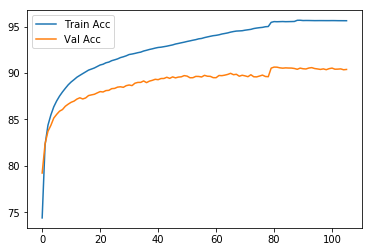

In [31]:
print('best test accuracy: {:.6f}'.format(best_acc112))
with open('model112_A_history.pkl','wb') as f:
    pickle.dump(history112,f)
torch.cuda.empty_cache()    

plt.plot(history112['acc'])
plt.plot(history112['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()


* Best val Accuracy so far : 90.631 epoch : 81 *


=====================================================

#### model 122

In [32]:
# model
torch.cuda.empty_cache()
best_acc122 = 0
em_iters = [1,2,2]
model122 = capsules(A=A, B=B, C=C, D=D, E=num_class,in_channels=1,
                 iters_routings=em_iters).to(device)
history122={'val_acc':[],'acc':[]}
optimizer122 = optim.Adam(model122.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 10, 3, 4, 1] 
iters for routings:  [1, 2, 2] 
stage output:  class_caps 
activation:  o


In [33]:
torch.cuda.empty_cache()

best_acc122= mainTrain('model122_A',epochs,model122,history122,optimizer122)

########### Training model model122_A ###########
Train Epoch: 1	[0/60000 (0%)]	Loss: 0.440200	Accuracy: 10.937500	
Train Epoch: 1	[6400/60000 (11%)]	Loss: 0.087498	Accuracy: 69.531250	
Train Epoch: 1	[12800/60000 (21%)]	Loss: 0.045920	Accuracy: 76.562500	
Train Epoch: 1	[19200/60000 (32%)]	Loss: 0.061873	Accuracy: 74.218750	
Train Epoch: 1	[25600/60000 (43%)]	Loss: 0.041783	Accuracy: 82.031250	
Train Epoch: 1	[32000/60000 (53%)]	Loss: 0.052980	Accuracy: 80.468750	
Train Epoch: 1	[38400/60000 (64%)]	Loss: 0.037917	Accuracy: 82.812500	
Train Epoch: 1	[44800/60000 (75%)]	Loss: 0.044924	Accuracy: 78.906250	
Train Epoch: 1	[51200/60000 (85%)]	Loss: 0.046313	Accuracy: 82.812500	
Train Epoch: 1	[57600/60000 (96%)]	Loss: 0.033802	Accuracy: 83.593750	
Epoch Train-loss : 0.0592, Epoch Train-accuracy : 76.1444
Test Completion: [------------------> ] 95%
Test set: Average loss: 4.004014, Accuracy: 79.979894 


saving model to FMnist_weights\model_model122_A_1.pth
Current Learning Rate : 0.0009990

Train Epoch: 8	[6400/60000 (11%)]	Loss: 0.038706	Accuracy: 84.375000	
Train Epoch: 8	[12800/60000 (21%)]	Loss: 0.023770	Accuracy: 84.375000	
Train Epoch: 8	[19200/60000 (32%)]	Loss: 0.032312	Accuracy: 85.937500	
Train Epoch: 8	[25600/60000 (43%)]	Loss: 0.021023	Accuracy: 89.062500	
Train Epoch: 8	[32000/60000 (53%)]	Loss: 0.035113	Accuracy: 85.156250	
Train Epoch: 8	[38400/60000 (64%)]	Loss: 0.024939	Accuracy: 87.500000	
Train Epoch: 8	[44800/60000 (75%)]	Loss: 0.034094	Accuracy: 85.156250	
Train Epoch: 8	[51200/60000 (85%)]	Loss: 0.030005	Accuracy: 89.843750	
Train Epoch: 8	[57600/60000 (96%)]	Loss: 0.025710	Accuracy: 89.062500	
Epoch Train-loss : 0.0268, Epoch Train-accuracy : 88.3534
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.256257, Accuracy: 86.682560 


saving model to FMnist_weights\model_model122_A_8.pth
Current Learning Rate : 0.000992371043175416
* Best val Accuracy so far : 86.683 epoch : 8 *
Total 1 epochs with no improvement in val_acc.
Epoch tim

Train Epoch: 15	[12800/60000 (21%)]	Loss: 0.021425	Accuracy: 89.843750	
Train Epoch: 15	[19200/60000 (32%)]	Loss: 0.032985	Accuracy: 88.281250	
Train Epoch: 15	[25600/60000 (43%)]	Loss: 0.018676	Accuracy: 93.750000	
Train Epoch: 15	[32000/60000 (53%)]	Loss: 0.036565	Accuracy: 85.937500	
Train Epoch: 15	[38400/60000 (64%)]	Loss: 0.025254	Accuracy: 90.625000	
Train Epoch: 15	[44800/60000 (75%)]	Loss: 0.032859	Accuracy: 90.625000	
Train Epoch: 15	[51200/60000 (85%)]	Loss: 0.024656	Accuracy: 92.187500	
Train Epoch: 15	[57600/60000 (96%)]	Loss: 0.025876	Accuracy: 90.625000	
Epoch Train-loss : 0.0257, Epoch Train-accuracy : 90.5678
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.957091, Accuracy: 87.872817 


saving model to FMnist_weights\model_model122_A_15.pth
Current Learning Rate : 0.0009857434641560286
* Best val Accuracy so far : 87.873 epoch : 15 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 5.31 mins
Train Epoch: 16	[0/60000 (0%)]	Loss: 0.013077	

Train Epoch: 22	[12800/60000 (21%)]	Loss: 0.019644	Accuracy: 91.406250	
Train Epoch: 22	[19200/60000 (32%)]	Loss: 0.033584	Accuracy: 92.968750	
Train Epoch: 22	[25600/60000 (43%)]	Loss: 0.020614	Accuracy: 92.968750	
Train Epoch: 22	[32000/60000 (53%)]	Loss: 0.034376	Accuracy: 89.843750	
Train Epoch: 22	[38400/60000 (64%)]	Loss: 0.027847	Accuracy: 92.187500	
Train Epoch: 22	[44800/60000 (75%)]	Loss: 0.033850	Accuracy: 89.843750	
Train Epoch: 22	[51200/60000 (85%)]	Loss: 0.024361	Accuracy: 93.750000	
Train Epoch: 22	[57600/60000 (96%)]	Loss: 0.028763	Accuracy: 89.062500	
Epoch Train-loss : 0.0263, Epoch Train-accuracy : 91.7472
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.779487, Accuracy: 88.033662 


saving model to FMnist_weights\model_model122_A_22.pth
Current Learning Rate : 0.00097916014761685
* Best val Accuracy so far : 88.034 epoch : 22 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 5.32 mins
Train Epoch: 23	[0/60000 (0%)]	Loss: 0.015859	Ac

Train Epoch: 29	[12800/60000 (21%)]	Loss: 0.020789	Accuracy: 92.968750	
Train Epoch: 29	[19200/60000 (32%)]	Loss: 0.035741	Accuracy: 92.968750	
Train Epoch: 29	[25600/60000 (43%)]	Loss: 0.021621	Accuracy: 93.750000	
Train Epoch: 29	[32000/60000 (53%)]	Loss: 0.036868	Accuracy: 89.062500	
Train Epoch: 29	[38400/60000 (64%)]	Loss: 0.026954	Accuracy: 92.968750	
Train Epoch: 29	[44800/60000 (75%)]	Loss: 0.036448	Accuracy: 90.625000	
Train Epoch: 29	[51200/60000 (85%)]	Loss: 0.024448	Accuracy: 92.968750	
Train Epoch: 29	[57600/60000 (96%)]	Loss: 0.030431	Accuracy: 91.406250	
Epoch Train-loss : 0.0275, Epoch Train-accuracy : 92.8155
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.629345, Accuracy: 87.998621 


saving model to FMnist_weights\model_model122_A_29.pth
Current Learning Rate : 0.000972620797949612
* Best val Accuracy so far : 88.069 epoch : 27 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 5.32 mins
Train Epoch: 30	[0/60000 (0%)]	Loss: 0.015333	A

Train Epoch: 36	[12800/60000 (21%)]	Loss: 0.022401	Accuracy: 92.187500	
Train Epoch: 36	[19200/60000 (32%)]	Loss: 0.036016	Accuracy: 93.750000	
Train Epoch: 36	[25600/60000 (43%)]	Loss: 0.024005	Accuracy: 94.531250	
Train Epoch: 36	[32000/60000 (53%)]	Loss: 0.038396	Accuracy: 90.625000	
Train Epoch: 36	[38400/60000 (64%)]	Loss: 0.029683	Accuracy: 91.406250	
Train Epoch: 36	[44800/60000 (75%)]	Loss: 0.038854	Accuracy: 90.625000	
Train Epoch: 36	[51200/60000 (85%)]	Loss: 0.027140	Accuracy: 95.312500	
Train Epoch: 36	[57600/60000 (96%)]	Loss: 0.031472	Accuracy: 92.187500	
Epoch Train-loss : 0.0286, Epoch Train-accuracy : 93.7728
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.543772, Accuracy: 87.734949 


saving model to FMnist_weights\model_model122_A_36.pth
Current Learning Rate : 0.0009661251215202755
* Best val Accuracy so far : 88.069 epoch : 27 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 5.31 mins
Train Epoch: 37	[0/60000 (0%)]	Loss: 0.017255	

Train Epoch: 43	[6400/60000 (11%)]	Loss: 0.041383	Accuracy: 89.843750	
Train Epoch: 43	[12800/60000 (21%)]	Loss: 0.019060	Accuracy: 96.093750	
Train Epoch: 43	[19200/60000 (32%)]	Loss: 0.036658	Accuracy: 92.187500	
Train Epoch: 43	[25600/60000 (43%)]	Loss: 0.032885	Accuracy: 93.750000	
Train Epoch: 43	[32000/60000 (53%)]	Loss: 0.037140	Accuracy: 90.625000	
Train Epoch: 43	[38400/60000 (64%)]	Loss: 0.029769	Accuracy: 92.187500	
Train Epoch: 43	[44800/60000 (75%)]	Loss: 0.036814	Accuracy: 92.187500	
Train Epoch: 43	[51200/60000 (85%)]	Loss: 0.023862	Accuracy: 97.656250	
Train Epoch: 43	[57600/60000 (96%)]	Loss: 0.025644	Accuracy: 96.093750	
Epoch Train-loss : 0.0286, Epoch Train-accuracy : 94.7883
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.430013, Accuracy: 89.042969 


saving model to FMnist_weights\model_model122_A_43.pth
Current Learning Rate : 9.596728266558443e-05
* Best val Accuracy so far : 89.043 epoch : 43 *
Total 1 epochs with no improvement in val_ac

Train Epoch: 50	[6400/60000 (11%)]	Loss: 0.045271	Accuracy: 89.843750	
Train Epoch: 50	[12800/60000 (21%)]	Loss: 0.020604	Accuracy: 96.093750	
Train Epoch: 50	[19200/60000 (32%)]	Loss: 0.041292	Accuracy: 92.968750	
Train Epoch: 50	[25600/60000 (43%)]	Loss: 0.036505	Accuracy: 92.968750	
Train Epoch: 50	[32000/60000 (53%)]	Loss: 0.043521	Accuracy: 91.406250	
Train Epoch: 50	[38400/60000 (64%)]	Loss: 0.033661	Accuracy: 92.968750	
Train Epoch: 50	[44800/60000 (75%)]	Loss: 0.043873	Accuracy: 92.968750	
Train Epoch: 50	[51200/60000 (85%)]	Loss: 0.029487	Accuracy: 97.656250	
Train Epoch: 50	[57600/60000 (96%)]	Loss: 0.031837	Accuracy: 96.093750	
Epoch Train-loss : 0.0330, Epoch Train-accuracy : 95.1015
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.409695, Accuracy: 89.076287 


saving model to FMnist_weights\model_model122_A_50.pth
Current Learning Rate : 9.532636236312693e-05
* Best val Accuracy so far : 89.178 epoch : 45 *
Total 5 epochs with no improvement in val_ac

Train Epoch: 57	[0/60000 (0%)]	Loss: 0.022208	Accuracy: 97.656250	
Train Epoch: 57	[6400/60000 (11%)]	Loss: 0.056361	Accuracy: 89.062500	
Train Epoch: 57	[12800/60000 (21%)]	Loss: 0.025416	Accuracy: 96.875000	
Train Epoch: 57	[19200/60000 (32%)]	Loss: 0.051393	Accuracy: 92.187500	
Train Epoch: 57	[25600/60000 (43%)]	Loss: 0.042314	Accuracy: 93.750000	
Train Epoch: 57	[32000/60000 (53%)]	Loss: 0.050816	Accuracy: 91.406250	
Train Epoch: 57	[38400/60000 (64%)]	Loss: 0.038812	Accuracy: 93.750000	
Train Epoch: 57	[44800/60000 (75%)]	Loss: 0.049046	Accuracy: 93.750000	
Train Epoch: 57	[51200/60000 (85%)]	Loss: 0.034746	Accuracy: 98.437500	
Train Epoch: 57	[57600/60000 (96%)]	Loss: 0.038387	Accuracy: 96.875000	
Epoch Train-loss : 0.0395, Epoch Train-accuracy : 95.2348
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.387837, Accuracy: 89.102137 


saving model to FMnist_weights\model_model122_A_57.pth
Current Learning Rate : 9.468972246564385e-06
* Best val Accuracy so far

Train Epoch: 64	[0/60000 (0%)]	Loss: 0.029632	Accuracy: 97.656250	
Train Epoch: 64	[6400/60000 (11%)]	Loss: 0.070091	Accuracy: 89.843750	
Train Epoch: 64	[12800/60000 (21%)]	Loss: 0.032802	Accuracy: 96.875000	
Train Epoch: 64	[19200/60000 (32%)]	Loss: 0.064011	Accuracy: 92.187500	
Train Epoch: 64	[25600/60000 (43%)]	Loss: 0.052507	Accuracy: 93.750000	
Train Epoch: 64	[32000/60000 (53%)]	Loss: 0.063230	Accuracy: 91.406250	
Train Epoch: 64	[38400/60000 (64%)]	Loss: 0.049340	Accuracy: 93.750000	
Train Epoch: 64	[44800/60000 (75%)]	Loss: 0.060652	Accuracy: 94.531250	
Train Epoch: 64	[51200/60000 (85%)]	Loss: 0.044456	Accuracy: 98.437500	
Train Epoch: 64	[57600/60000 (96%)]	Loss: 0.047911	Accuracy: 96.875000	
Epoch Train-loss : 0.0497, Epoch Train-accuracy : 95.2431
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.382471, Accuracy: 89.092371 


saving model to FMnist_weights\model_model122_A_64.pth
Current Learning Rate : 9.405733438632544e-07
* Best val Accuracy so far

Train Epoch: 71	[0/60000 (0%)]	Loss: 0.040703	Accuracy: 97.656250	
Train Epoch: 71	[6400/60000 (11%)]	Loss: 0.087687	Accuracy: 89.843750	
Train Epoch: 71	[12800/60000 (21%)]	Loss: 0.043077	Accuracy: 96.875000	
Train Epoch: 71	[19200/60000 (32%)]	Loss: 0.080319	Accuracy: 92.187500	
Train Epoch: 71	[25600/60000 (43%)]	Loss: 0.066616	Accuracy: 93.750000	
Train Epoch: 71	[32000/60000 (53%)]	Loss: 0.079319	Accuracy: 91.406250	
Train Epoch: 71	[38400/60000 (64%)]	Loss: 0.063823	Accuracy: 93.750000	
Train Epoch: 71	[44800/60000 (75%)]	Loss: 0.076371	Accuracy: 93.750000	
Train Epoch: 71	[51200/60000 (85%)]	Loss: 0.058364	Accuracy: 98.437500	
Train Epoch: 71	[57600/60000 (96%)]	Loss: 0.061312	Accuracy: 96.875000	
Epoch Train-loss : 0.0638, Epoch Train-accuracy : 95.2148
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.383053, Accuracy: 89.023438 


saving model to FMnist_weights\model_model122_A_71.pth
Current Learning Rate : 9.34291697292798e-08
* Best val Accuracy so far 

Train Epoch: 78	[0/60000 (0%)]	Loss: 0.057654	Accuracy: 97.656250	
Train Epoch: 78	[6400/60000 (11%)]	Loss: 0.111401	Accuracy: 89.843750	
Train Epoch: 78	[12800/60000 (21%)]	Loss: 0.058697	Accuracy: 96.875000	
Train Epoch: 78	[19200/60000 (32%)]	Loss: 0.102998	Accuracy: 92.187500	
Train Epoch: 78	[25600/60000 (43%)]	Loss: 0.086958	Accuracy: 93.750000	
Train Epoch: 78	[32000/60000 (53%)]	Loss: 0.101385	Accuracy: 91.406250	
Train Epoch: 78	[38400/60000 (64%)]	Loss: 0.084739	Accuracy: 93.750000	
Train Epoch: 78	[44800/60000 (75%)]	Loss: 0.098158	Accuracy: 93.750000	
Train Epoch: 78	[51200/60000 (85%)]	Loss: 0.078589	Accuracy: 98.437500	
Train Epoch: 78	[57600/60000 (96%)]	Loss: 0.080965	Accuracy: 96.875000	
Epoch Train-loss : 0.0841, Epoch Train-accuracy : 95.2114
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.382749, Accuracy: 89.040671 


saving model to FMnist_weights\model_model122_A_78.pth
Current Learning Rate : 9.280520028825782e-09
* Best val Accuracy so far

Train Epoch: 85	[0/60000 (0%)]	Loss: 0.083504	Accuracy: 97.656250	
Train Epoch: 85	[6400/60000 (11%)]	Loss: 0.144303	Accuracy: 89.843750	
Train Epoch: 85	[12800/60000 (21%)]	Loss: 0.083075	Accuracy: 96.875000	
Train Epoch: 85	[19200/60000 (32%)]	Loss: 0.134967	Accuracy: 92.187500	
Train Epoch: 85	[25600/60000 (43%)]	Loss: 0.116593	Accuracy: 93.750000	
Train Epoch: 85	[32000/60000 (53%)]	Loss: 0.132565	Accuracy: 91.406250	
Train Epoch: 85	[38400/60000 (64%)]	Loss: 0.115046	Accuracy: 93.750000	
Train Epoch: 85	[44800/60000 (75%)]	Loss: 0.129181	Accuracy: 93.750000	
Train Epoch: 85	[51200/60000 (85%)]	Loss: 0.108085	Accuracy: 98.437500	
Train Epoch: 85	[57600/60000 (96%)]	Loss: 0.110113	Accuracy: 96.875000	
Epoch Train-loss : 0.1136, Epoch Train-accuracy : 95.2114
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.381564, Accuracy: 89.049287 


saving model to FMnist_weights\model_model122_A_85.pth
Current Learning Rate : 9.218539804538667e-10
* Best val Accuracy so far

best test accuracy: 89.178539


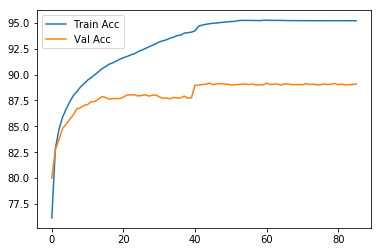

In [34]:
print('best test accuracy: {:.6f}'.format(best_acc122))
with open('model122_A_history.pkl','wb') as f:
    pickle.dump(history122,f)
torch.cuda.empty_cache()    

plt.plot(history122['acc'])
plt.plot(history122['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 89.179 epoch : 61 *


=====================================================
#### model 223

In [35]:
# model
torch.cuda.empty_cache()    
best_acc223 = 0
em_iters = [2,2,3]
model223 = capsules(A=A, B=B, C=C, D=D, E=num_class,in_channels=1,
                 iters_routings=em_iters).to(device)
history223={'val_acc':[],'acc':[]}
optimizer223 = optim.Adam(model223.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 10, 3, 4, 1] 
iters for routings:  [2, 2, 3] 
stage output:  class_caps 
activation:  o


In [36]:
# model223.load_state_dict(torch.load('caps_train_v3\\model_model223_A_122.pth'))
# history223['val_acc']=history223['val_acc'][:122]
# history223['acc']=history223['acc'][:122]

In [37]:
torch.cuda.empty_cache()    

best_acc223 = mainTrain('model223_A',epochs,model223,history223,
        optimizer223,previous_epochs=0,best_acc=0, best_epoch = 1)

########### Training model model223_A ###########
Train Epoch: 1	[0/60000 (0%)]	Loss: 0.484554	Accuracy: 7.031250	
Train Epoch: 1	[6400/60000 (11%)]	Loss: 0.128170	Accuracy: 65.625000	
Train Epoch: 1	[12800/60000 (21%)]	Loss: 0.076653	Accuracy: 71.093750	
Train Epoch: 1	[19200/60000 (32%)]	Loss: 0.084221	Accuracy: 67.968750	
Train Epoch: 1	[25600/60000 (43%)]	Loss: 0.056907	Accuracy: 75.781250	
Train Epoch: 1	[32000/60000 (53%)]	Loss: 0.067242	Accuracy: 75.000000	
Train Epoch: 1	[38400/60000 (64%)]	Loss: 0.055070	Accuracy: 77.343750	
Train Epoch: 1	[44800/60000 (75%)]	Loss: 0.058648	Accuracy: 76.562500	
Train Epoch: 1	[51200/60000 (85%)]	Loss: 0.056902	Accuracy: 75.781250	
Train Epoch: 1	[57600/60000 (96%)]	Loss: 0.045916	Accuracy: 80.468750	
Epoch Train-loss : 0.0849, Epoch Train-accuracy : 69.7733
Test Completion: [------------------> ] 95%
Test set: Average loss: 4.364350, Accuracy: 76.746323 


saving model to FMnist_weights\model_model223_A_1.pth
Current Learning Rate : 0.00099904

Train Epoch: 8	[6400/60000 (11%)]	Loss: 0.039570	Accuracy: 88.281250	
Train Epoch: 8	[12800/60000 (21%)]	Loss: 0.025692	Accuracy: 85.156250	
Train Epoch: 8	[19200/60000 (32%)]	Loss: 0.030913	Accuracy: 84.375000	
Train Epoch: 8	[25600/60000 (43%)]	Loss: 0.019953	Accuracy: 91.406250	
Train Epoch: 8	[32000/60000 (53%)]	Loss: 0.034799	Accuracy: 84.375000	
Train Epoch: 8	[38400/60000 (64%)]	Loss: 0.029140	Accuracy: 89.062500	
Train Epoch: 8	[44800/60000 (75%)]	Loss: 0.041293	Accuracy: 84.375000	
Train Epoch: 8	[51200/60000 (85%)]	Loss: 0.033814	Accuracy: 88.281250	
Train Epoch: 8	[57600/60000 (96%)]	Loss: 0.027556	Accuracy: 86.718750	
Epoch Train-loss : 0.0314, Epoch Train-accuracy : 86.6416
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.382644, Accuracy: 84.830537 


saving model to FMnist_weights\model_model223_A_8.pth
Current Learning Rate : 0.000992371043175416
* Best val Accuracy so far : 84.831 epoch : 8 *
Total 1 epochs with no improvement in val_acc.
Epoch tim

Train Epoch: 15	[12800/60000 (21%)]	Loss: 0.021533	Accuracy: 89.062500	
Train Epoch: 15	[19200/60000 (32%)]	Loss: 0.032984	Accuracy: 89.843750	
Train Epoch: 15	[25600/60000 (43%)]	Loss: 0.017003	Accuracy: 93.750000	
Train Epoch: 15	[32000/60000 (53%)]	Loss: 0.034390	Accuracy: 85.937500	
Train Epoch: 15	[38400/60000 (64%)]	Loss: 0.028169	Accuracy: 90.625000	
Train Epoch: 15	[44800/60000 (75%)]	Loss: 0.039853	Accuracy: 87.500000	
Train Epoch: 15	[51200/60000 (85%)]	Loss: 0.032791	Accuracy: 88.281250	
Train Epoch: 15	[57600/60000 (96%)]	Loss: 0.028021	Accuracy: 88.281250	
Epoch Train-loss : 0.0285, Epoch Train-accuracy : 89.5028
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.135050, Accuracy: 85.649127 


saving model to FMnist_weights\model_model223_A_15.pth
Current Learning Rate : 0.0009857434641560286
* Best val Accuracy so far : 85.649 epoch : 15 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 6.21 mins
Train Epoch: 16	[0/60000 (0%)]	Loss: 0.018799	

Train Epoch: 22	[12800/60000 (21%)]	Loss: 0.020402	Accuracy: 92.968750	
Train Epoch: 22	[19200/60000 (32%)]	Loss: 0.030617	Accuracy: 90.625000	
Train Epoch: 22	[25600/60000 (43%)]	Loss: 0.020350	Accuracy: 93.750000	
Train Epoch: 22	[32000/60000 (53%)]	Loss: 0.046107	Accuracy: 85.156250	
Train Epoch: 22	[38400/60000 (64%)]	Loss: 0.023663	Accuracy: 90.625000	
Train Epoch: 22	[44800/60000 (75%)]	Loss: 0.032031	Accuracy: 90.625000	
Train Epoch: 22	[51200/60000 (85%)]	Loss: 0.031246	Accuracy: 89.843750	
Train Epoch: 22	[57600/60000 (96%)]	Loss: 0.027720	Accuracy: 89.062500	
Epoch Train-loss : 0.0276, Epoch Train-accuracy : 91.3757
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.974236, Accuracy: 86.115579 


saving model to FMnist_weights\model_model223_A_22.pth
Current Learning Rate : 0.00097916014761685
* Best val Accuracy so far : 86.310 epoch : 19 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 6.20 mins
Train Epoch: 23	[0/60000 (0%)]	Loss: 0.016824	Ac

Train Epoch: 29	[12800/60000 (21%)]	Loss: 0.021539	Accuracy: 92.187500	
Train Epoch: 29	[19200/60000 (32%)]	Loss: 0.029486	Accuracy: 90.625000	
Train Epoch: 29	[25600/60000 (43%)]	Loss: 0.018716	Accuracy: 94.531250	
Train Epoch: 29	[32000/60000 (53%)]	Loss: 0.048121	Accuracy: 86.718750	
Train Epoch: 29	[38400/60000 (64%)]	Loss: 0.023054	Accuracy: 94.531250	
Train Epoch: 29	[44800/60000 (75%)]	Loss: 0.033931	Accuracy: 90.625000	
Train Epoch: 29	[51200/60000 (85%)]	Loss: 0.026418	Accuracy: 91.406250	
Train Epoch: 29	[57600/60000 (96%)]	Loss: 0.030368	Accuracy: 89.843750	
Epoch Train-loss : 0.0275, Epoch Train-accuracy : 92.8249
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.873057, Accuracy: 86.394186 


saving model to FMnist_weights\model_model223_A_29.pth
Current Learning Rate : 0.000972620797949612
* Best val Accuracy so far : 86.609 epoch : 28 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 6.22 mins
Train Epoch: 30	[0/60000 (0%)]	Loss: 0.016713	A

Train Epoch: 36	[12800/60000 (21%)]	Loss: 0.026344	Accuracy: 92.968750	
Train Epoch: 36	[19200/60000 (32%)]	Loss: 0.031455	Accuracy: 93.750000	
Train Epoch: 36	[25600/60000 (43%)]	Loss: 0.021538	Accuracy: 96.093750	
Train Epoch: 36	[32000/60000 (53%)]	Loss: 0.043178	Accuracy: 90.625000	
Train Epoch: 36	[38400/60000 (64%)]	Loss: 0.025588	Accuracy: 94.531250	
Train Epoch: 36	[44800/60000 (75%)]	Loss: 0.037980	Accuracy: 91.406250	
Train Epoch: 36	[51200/60000 (85%)]	Loss: 0.026664	Accuracy: 93.750000	
Train Epoch: 36	[57600/60000 (96%)]	Loss: 0.038097	Accuracy: 91.406250	
Epoch Train-loss : 0.0282, Epoch Train-accuracy : 94.0171
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.805997, Accuracy: 86.692325 


saving model to FMnist_weights\model_model223_A_36.pth
Current Learning Rate : 0.0009661251215202755
* Best val Accuracy so far : 87.159 epoch : 35 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 6.22 mins
Train Epoch: 37	[0/60000 (0%)]	Loss: 0.018613	

Train Epoch: 43	[12800/60000 (21%)]	Loss: 0.030249	Accuracy: 92.968750	
Train Epoch: 43	[19200/60000 (32%)]	Loss: 0.036808	Accuracy: 91.406250	
Train Epoch: 43	[25600/60000 (43%)]	Loss: 0.021018	Accuracy: 95.312500	
Train Epoch: 43	[32000/60000 (53%)]	Loss: 0.043436	Accuracy: 92.187500	
Train Epoch: 43	[38400/60000 (64%)]	Loss: 0.028392	Accuracy: 94.531250	
Train Epoch: 43	[44800/60000 (75%)]	Loss: 0.046447	Accuracy: 90.625000	
Train Epoch: 43	[51200/60000 (85%)]	Loss: 0.028588	Accuracy: 94.531250	
Train Epoch: 43	[57600/60000 (96%)]	Loss: 0.038679	Accuracy: 91.406250	
Epoch Train-loss : 0.0293, Epoch Train-accuracy : 95.0232
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.778153, Accuracy: 86.357422 


saving model to FMnist_weights\model_model223_A_43.pth
Current Learning Rate : 0.0009596728266558442
* Best val Accuracy so far : 87.159 epoch : 35 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 6.21 mins
Train Epoch: 44	[0/60000 (0%)]	Loss: 0.014223	

Train Epoch: 50	[6400/60000 (11%)]	Loss: 0.036790	Accuracy: 94.531250	
Train Epoch: 50	[12800/60000 (21%)]	Loss: 0.022720	Accuracy: 94.531250	
Train Epoch: 50	[19200/60000 (32%)]	Loss: 0.030772	Accuracy: 96.093750	
Train Epoch: 50	[25600/60000 (43%)]	Loss: 0.024438	Accuracy: 95.312500	
Train Epoch: 50	[32000/60000 (53%)]	Loss: 0.057962	Accuracy: 91.406250	
Train Epoch: 50	[38400/60000 (64%)]	Loss: 0.043471	Accuracy: 93.750000	
Train Epoch: 50	[44800/60000 (75%)]	Loss: 0.030251	Accuracy: 95.312500	
Train Epoch: 50	[51200/60000 (85%)]	Loss: 0.020883	Accuracy: 97.656250	
Train Epoch: 50	[57600/60000 (96%)]	Loss: 0.023981	Accuracy: 96.093750	
Epoch Train-loss : 0.0298, Epoch Train-accuracy : 95.9277
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.662941, Accuracy: 87.566061 


saving model to FMnist_weights\model_model223_A_50.pth
Current Learning Rate : 9.532636236312693e-05
* Best val Accuracy so far : 87.657 epoch : 49 *
Total 1 epochs with no improvement in val_ac

Train Epoch: 57	[0/60000 (0%)]	Loss: 0.020115	Accuracy: 98.437500	
Train Epoch: 57	[6400/60000 (11%)]	Loss: 0.044018	Accuracy: 94.531250	
Train Epoch: 57	[12800/60000 (21%)]	Loss: 0.020916	Accuracy: 96.875000	
Train Epoch: 57	[19200/60000 (32%)]	Loss: 0.040615	Accuracy: 95.312500	
Train Epoch: 57	[25600/60000 (43%)]	Loss: 0.033599	Accuracy: 95.312500	
Train Epoch: 57	[32000/60000 (53%)]	Loss: 0.062409	Accuracy: 91.406250	
Train Epoch: 57	[38400/60000 (64%)]	Loss: 0.031114	Accuracy: 96.093750	
Train Epoch: 57	[44800/60000 (75%)]	Loss: 0.028051	Accuracy: 96.093750	
Train Epoch: 57	[51200/60000 (85%)]	Loss: 0.022839	Accuracy: 98.437500	
Train Epoch: 57	[57600/60000 (96%)]	Loss: 0.025758	Accuracy: 98.437500	
Epoch Train-loss : 0.0313, Epoch Train-accuracy : 96.8472
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.650434, Accuracy: 87.595933 


saving model to FMnist_weights\model_model223_A_57.pth
Current Learning Rate : 9.468972246564385e-06
* Best val Accuracy so far

Train Epoch: 64	[0/60000 (0%)]	Loss: 0.027462	Accuracy: 99.218750	
Train Epoch: 64	[6400/60000 (11%)]	Loss: 0.048927	Accuracy: 94.531250	
Train Epoch: 64	[12800/60000 (21%)]	Loss: 0.027157	Accuracy: 96.875000	
Train Epoch: 64	[19200/60000 (32%)]	Loss: 0.047916	Accuracy: 96.875000	
Train Epoch: 64	[25600/60000 (43%)]	Loss: 0.037935	Accuracy: 95.312500	
Train Epoch: 64	[32000/60000 (53%)]	Loss: 0.071423	Accuracy: 92.187500	
Train Epoch: 64	[38400/60000 (64%)]	Loss: 0.040354	Accuracy: 96.093750	
Train Epoch: 64	[44800/60000 (75%)]	Loss: 0.038913	Accuracy: 97.656250	
Train Epoch: 64	[51200/60000 (85%)]	Loss: 0.032782	Accuracy: 98.437500	
Train Epoch: 64	[57600/60000 (96%)]	Loss: 0.036928	Accuracy: 98.437500	
Epoch Train-loss : 0.0401, Epoch Train-accuracy : 97.0221
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.646157, Accuracy: 87.612017 


saving model to FMnist_weights\model_model223_A_64.pth
Current Learning Rate : 9.405733438632543e-06
* Best val Accuracy so far

Train Epoch: 71	[0/60000 (0%)]	Loss: 0.041025	Accuracy: 99.218750	
Train Epoch: 71	[6400/60000 (11%)]	Loss: 0.067314	Accuracy: 94.531250	
Train Epoch: 71	[12800/60000 (21%)]	Loss: 0.039639	Accuracy: 96.875000	
Train Epoch: 71	[19200/60000 (32%)]	Loss: 0.065991	Accuracy: 96.875000	
Train Epoch: 71	[25600/60000 (43%)]	Loss: 0.052674	Accuracy: 95.312500	
Train Epoch: 71	[32000/60000 (53%)]	Loss: 0.092354	Accuracy: 92.187500	
Train Epoch: 71	[38400/60000 (64%)]	Loss: 0.054935	Accuracy: 96.875000	
Train Epoch: 71	[44800/60000 (75%)]	Loss: 0.054570	Accuracy: 97.656250	
Train Epoch: 71	[51200/60000 (85%)]	Loss: 0.048641	Accuracy: 97.656250	
Train Epoch: 71	[57600/60000 (96%)]	Loss: 0.052556	Accuracy: 98.437500	
Epoch Train-loss : 0.0559, Epoch Train-accuracy : 97.0688
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.641634, Accuracy: 87.518957 


saving model to FMnist_weights\model_model223_A_71.pth
Current Learning Rate : 9.34291697292798e-07
* Best val Accuracy so far 

Train Epoch: 78	[0/60000 (0%)]	Loss: 0.064665	Accuracy: 99.218750	
Train Epoch: 78	[6400/60000 (11%)]	Loss: 0.094952	Accuracy: 94.531250	
Train Epoch: 78	[12800/60000 (21%)]	Loss: 0.062141	Accuracy: 96.875000	
Train Epoch: 78	[19200/60000 (32%)]	Loss: 0.094462	Accuracy: 96.875000	
Train Epoch: 78	[25600/60000 (43%)]	Loss: 0.078117	Accuracy: 96.093750	
Train Epoch: 78	[32000/60000 (53%)]	Loss: 0.122620	Accuracy: 92.187500	
Train Epoch: 78	[38400/60000 (64%)]	Loss: 0.081216	Accuracy: 96.875000	
Train Epoch: 78	[44800/60000 (75%)]	Loss: 0.080732	Accuracy: 97.656250	
Train Epoch: 78	[51200/60000 (85%)]	Loss: 0.074265	Accuracy: 98.437500	
Train Epoch: 78	[57600/60000 (96%)]	Loss: 0.078705	Accuracy: 98.437500	
Epoch Train-loss : 0.0818, Epoch Train-accuracy : 97.0638
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.641235, Accuracy: 87.464959 


saving model to FMnist_weights\model_model223_A_78.pth
Current Learning Rate : 9.28052002882578e-08
* Best val Accuracy so far 

Train Epoch: 85	[0/60000 (0%)]	Loss: 0.099163	Accuracy: 99.218750	
Train Epoch: 85	[6400/60000 (11%)]	Loss: 0.133657	Accuracy: 94.531250	
Train Epoch: 85	[12800/60000 (21%)]	Loss: 0.095273	Accuracy: 96.875000	
Train Epoch: 85	[19200/60000 (32%)]	Loss: 0.133691	Accuracy: 96.875000	
Train Epoch: 85	[25600/60000 (43%)]	Loss: 0.114472	Accuracy: 96.093750	
Train Epoch: 85	[32000/60000 (53%)]	Loss: 0.163846	Accuracy: 92.187500	
Train Epoch: 85	[38400/60000 (64%)]	Loss: 0.118370	Accuracy: 96.875000	
Train Epoch: 85	[44800/60000 (75%)]	Loss: 0.117673	Accuracy: 97.656250	
Train Epoch: 85	[51200/60000 (85%)]	Loss: 0.110643	Accuracy: 98.437500	
Train Epoch: 85	[57600/60000 (96%)]	Loss: 0.115773	Accuracy: 98.437500	
Epoch Train-loss : 0.1186, Epoch Train-accuracy : 97.0588
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.637222, Accuracy: 87.568359 


saving model to FMnist_weights\model_model223_A_85.pth
Current Learning Rate : 9.218539804538667e-09
* Best val Accuracy so far

In [38]:
with open('model223_A_history.pkl','wb') as f:
    pickle.dump(history223,f)
print('best test accuracy: {:.6f}'.format(best_acc223))

best test accuracy: 87.738971


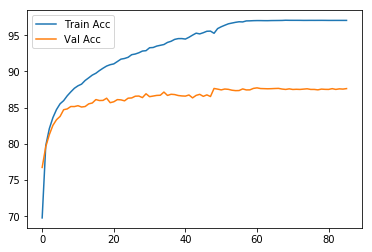

In [39]:
plt.plot(history223['acc'])
plt.plot(history223['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

In [40]:
# with open('model223_A_history.pkl','rb') as f:
#     history223=pickle.load(f)

* Best val Accuracy so far : 87.739 epoch : 61 *


=====================================================
#### model 221

In [41]:
# model
torch.cuda.empty_cache()    
best_acc221 = 0
em_iters = [2,2,1]
model221 = capsules(A=A, B=B, C=C, D=D, E=num_class,in_channels=1,
                 iters_routings=em_iters).to(device)
history221={'val_acc':[],'acc':[]}
optimizer221 = optim.Adam(model221.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 10, 3, 4, 1] 
iters for routings:  [2, 2, 1] 
stage output:  class_caps 
activation:  o


In [42]:
# model221.load_state_dict(torch.load('face_weights\\model_model221_A_11.pth'))

In [43]:
torch.cuda.empty_cache()    

best_acc221 = mainTrain('model221_A',epochs,model221,history221,optimizer221)

########### Training model model221_A ###########
Train Epoch: 1	[0/60000 (0%)]	Loss: 0.359559	Accuracy: 6.250000	
Train Epoch: 1	[6400/60000 (11%)]	Loss: 0.334952	Accuracy: 50.781250	
Train Epoch: 1	[12800/60000 (21%)]	Loss: 0.298522	Accuracy: 64.062500	
Train Epoch: 1	[19200/60000 (32%)]	Loss: 0.277734	Accuracy: 50.781250	
Train Epoch: 1	[25600/60000 (43%)]	Loss: 0.216495	Accuracy: 63.281250	
Train Epoch: 1	[32000/60000 (53%)]	Loss: 0.209191	Accuracy: 57.812500	
Train Epoch: 1	[38400/60000 (64%)]	Loss: 0.174604	Accuracy: 53.125000	
Train Epoch: 1	[44800/60000 (75%)]	Loss: 0.164269	Accuracy: 58.593750	
Train Epoch: 1	[51200/60000 (85%)]	Loss: 0.143440	Accuracy: 58.593750	
Train Epoch: 1	[57600/60000 (96%)]	Loss: 0.121640	Accuracy: 61.718750	
Epoch Train-loss : 0.2250, Epoch Train-accuracy : 55.2522
Test Completion: [------------------> ] 95%
Test set: Average loss: 5.703654, Accuracy: 62.219669 


saving model to FMnist_weights\model_model221_A_1.pth
Current Learning Rate : 0.00099904

Train Epoch: 8	[6400/60000 (11%)]	Loss: 0.071151	Accuracy: 76.562500	
Train Epoch: 8	[12800/60000 (21%)]	Loss: 0.049333	Accuracy: 79.687500	
Train Epoch: 8	[19200/60000 (32%)]	Loss: 0.063781	Accuracy: 75.000000	
Train Epoch: 8	[25600/60000 (43%)]	Loss: 0.052963	Accuracy: 82.812500	
Train Epoch: 8	[32000/60000 (53%)]	Loss: 0.054574	Accuracy: 79.687500	
Train Epoch: 8	[38400/60000 (64%)]	Loss: 0.055808	Accuracy: 83.593750	
Train Epoch: 8	[44800/60000 (75%)]	Loss: 0.066356	Accuracy: 78.906250	
Train Epoch: 8	[51200/60000 (85%)]	Loss: 0.056937	Accuracy: 75.781250	
Train Epoch: 8	[57600/60000 (96%)]	Loss: 0.058269	Accuracy: 81.250000	
Epoch Train-loss : 0.0600, Epoch Train-accuracy : 78.7808
Test Completion: [------------------> ] 95%
Test set: Average loss: 4.317476, Accuracy: 78.926356 


saving model to FMnist_weights\model_model221_A_8.pth
Current Learning Rate : 0.000992371043175416
* Best val Accuracy so far : 78.926 epoch : 8 *
Total 1 epochs with no improvement in val_acc.
Epoch tim

Train Epoch: 15	[12800/60000 (21%)]	Loss: 0.053580	Accuracy: 84.375000	
Train Epoch: 15	[19200/60000 (32%)]	Loss: 0.060968	Accuracy: 75.781250	
Train Epoch: 15	[25600/60000 (43%)]	Loss: 0.040283	Accuracy: 85.156250	
Train Epoch: 15	[32000/60000 (53%)]	Loss: 0.068935	Accuracy: 80.468750	
Train Epoch: 15	[38400/60000 (64%)]	Loss: 0.049846	Accuracy: 88.281250	
Train Epoch: 15	[44800/60000 (75%)]	Loss: 0.061684	Accuracy: 81.250000	
Train Epoch: 15	[51200/60000 (85%)]	Loss: 0.050641	Accuracy: 83.593750	
Train Epoch: 15	[57600/60000 (96%)]	Loss: 0.051348	Accuracy: 85.156250	
Epoch Train-loss : 0.0569, Epoch Train-accuracy : 83.0518
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.867380, Accuracy: 81.271829 


saving model to FMnist_weights\model_model221_A_15.pth
Current Learning Rate : 0.0009857434641560286
* Best val Accuracy so far : 81.368 epoch : 13 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 6.08 mins
Train Epoch: 16	[0/60000 (0%)]	Loss: 0.043355	

Train Epoch: 22	[12800/60000 (21%)]	Loss: 0.053220	Accuracy: 86.718750	
Train Epoch: 22	[19200/60000 (32%)]	Loss: 0.059641	Accuracy: 80.468750	
Train Epoch: 22	[25600/60000 (43%)]	Loss: 0.042909	Accuracy: 89.062500	
Train Epoch: 22	[32000/60000 (53%)]	Loss: 0.072227	Accuracy: 82.812500	
Train Epoch: 22	[38400/60000 (64%)]	Loss: 0.060088	Accuracy: 87.500000	
Train Epoch: 22	[44800/60000 (75%)]	Loss: 0.068997	Accuracy: 84.375000	
Train Epoch: 22	[51200/60000 (85%)]	Loss: 0.054821	Accuracy: 90.625000	
Train Epoch: 22	[57600/60000 (96%)]	Loss: 0.049992	Accuracy: 85.156250	
Epoch Train-loss : 0.0597, Epoch Train-accuracy : 85.0941
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.621519, Accuracy: 83.166935 


saving model to FMnist_weights\model_model221_A_22.pth
Current Learning Rate : 0.00097916014761685
* Best val Accuracy so far : 83.292 epoch : 21 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 6.08 mins
Train Epoch: 23	[0/60000 (0%)]	Loss: 0.046155	Ac

Train Epoch: 29	[12800/60000 (21%)]	Loss: 0.053238	Accuracy: 88.281250	
Train Epoch: 29	[19200/60000 (32%)]	Loss: 0.062020	Accuracy: 82.031250	
Train Epoch: 29	[25600/60000 (43%)]	Loss: 0.048156	Accuracy: 89.843750	
Train Epoch: 29	[32000/60000 (53%)]	Loss: 0.085598	Accuracy: 78.906250	
Train Epoch: 29	[38400/60000 (64%)]	Loss: 0.068930	Accuracy: 87.500000	
Train Epoch: 29	[44800/60000 (75%)]	Loss: 0.084072	Accuracy: 84.375000	
Train Epoch: 29	[51200/60000 (85%)]	Loss: 0.067537	Accuracy: 88.281250	
Train Epoch: 29	[57600/60000 (96%)]	Loss: 0.048174	Accuracy: 85.156250	
Epoch Train-loss : 0.0660, Epoch Train-accuracy : 85.9919
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.409804, Accuracy: 83.714959 


saving model to FMnist_weights\model_model221_A_29.pth
Current Learning Rate : 0.000972620797949612
* Best val Accuracy so far : 83.715 epoch : 29 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 6.08 mins
Train Epoch: 30	[0/60000 (0%)]	Loss: 0.052880	A

Train Epoch: 36	[12800/60000 (21%)]	Loss: 0.050384	Accuracy: 89.843750	
Train Epoch: 36	[19200/60000 (32%)]	Loss: 0.069005	Accuracy: 80.468750	
Train Epoch: 36	[25600/60000 (43%)]	Loss: 0.053001	Accuracy: 90.625000	
Train Epoch: 36	[32000/60000 (53%)]	Loss: 0.094648	Accuracy: 78.906250	
Train Epoch: 36	[38400/60000 (64%)]	Loss: 0.073414	Accuracy: 87.500000	
Train Epoch: 36	[44800/60000 (75%)]	Loss: 0.091341	Accuracy: 82.812500	
Train Epoch: 36	[51200/60000 (85%)]	Loss: 0.080580	Accuracy: 88.281250	
Train Epoch: 36	[57600/60000 (96%)]	Loss: 0.055523	Accuracy: 89.843750	
Epoch Train-loss : 0.0725, Epoch Train-accuracy : 86.8043
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.208891, Accuracy: 83.464499 


saving model to FMnist_weights\model_model221_A_36.pth
Current Learning Rate : 0.0009661251215202755
* Best val Accuracy so far : 83.715 epoch : 29 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 6.01 mins
Train Epoch: 37	[0/60000 (0%)]	Loss: 0.053723	

Train Epoch: 43	[12800/60000 (21%)]	Loss: 0.059316	Accuracy: 88.281250	
Train Epoch: 43	[19200/60000 (32%)]	Loss: 0.075204	Accuracy: 85.156250	
Train Epoch: 43	[25600/60000 (43%)]	Loss: 0.060772	Accuracy: 89.843750	
Train Epoch: 43	[32000/60000 (53%)]	Loss: 0.114404	Accuracy: 78.906250	
Train Epoch: 43	[38400/60000 (64%)]	Loss: 0.085604	Accuracy: 90.625000	
Train Epoch: 43	[44800/60000 (75%)]	Loss: 0.107225	Accuracy: 84.375000	
Train Epoch: 43	[51200/60000 (85%)]	Loss: 0.085823	Accuracy: 89.843750	
Train Epoch: 43	[57600/60000 (96%)]	Loss: 0.058357	Accuracy: 90.625000	
Epoch Train-loss : 0.0812, Epoch Train-accuracy : 87.2368
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.065241, Accuracy: 83.274356 


saving model to FMnist_weights\model_model221_A_43.pth
Current Learning Rate : 0.0009596728266558442
* Best val Accuracy so far : 84.025 epoch : 39 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 6.08 mins
Train Epoch: 44	[0/60000 (0%)]	Loss: 0.058152	

Train Epoch: 50	[12800/60000 (21%)]	Loss: 0.068418	Accuracy: 89.062500	
Train Epoch: 50	[19200/60000 (32%)]	Loss: 0.084692	Accuracy: 86.718750	
Train Epoch: 50	[25600/60000 (43%)]	Loss: 0.065848	Accuracy: 92.187500	
Train Epoch: 50	[32000/60000 (53%)]	Loss: 0.135885	Accuracy: 82.031250	
Train Epoch: 50	[38400/60000 (64%)]	Loss: 0.088623	Accuracy: 90.625000	
Train Epoch: 50	[44800/60000 (75%)]	Loss: 0.123803	Accuracy: 84.375000	
Train Epoch: 50	[51200/60000 (85%)]	Loss: 0.101064	Accuracy: 87.500000	
Train Epoch: 50	[57600/60000 (96%)]	Loss: 0.064647	Accuracy: 90.625000	
Epoch Train-loss : 0.0901, Epoch Train-accuracy : 87.6505
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.966384, Accuracy: 82.945772 


saving model to FMnist_weights\model_model221_A_50.pth
Current Learning Rate : 0.0009532636236312693
* Best val Accuracy so far : 84.025 epoch : 39 *
Total 11 epochs with no improvement in val_acc.
Epoch time: 6.08 mins
Train Epoch: 51	[0/60000 (0%)]	Loss: 0.066780

Train Epoch: 57	[6400/60000 (11%)]	Loss: 0.126596	Accuracy: 84.375000	
Train Epoch: 57	[12800/60000 (21%)]	Loss: 0.072465	Accuracy: 90.625000	
Train Epoch: 57	[19200/60000 (32%)]	Loss: 0.082400	Accuracy: 88.281250	
Train Epoch: 57	[25600/60000 (43%)]	Loss: 0.071915	Accuracy: 91.406250	
Train Epoch: 57	[32000/60000 (53%)]	Loss: 0.138023	Accuracy: 82.812500	
Train Epoch: 57	[38400/60000 (64%)]	Loss: 0.106802	Accuracy: 85.937500	
Train Epoch: 57	[44800/60000 (75%)]	Loss: 0.114692	Accuracy: 85.937500	
Train Epoch: 57	[51200/60000 (85%)]	Loss: 0.104322	Accuracy: 87.500000	
Train Epoch: 57	[57600/60000 (96%)]	Loss: 0.062125	Accuracy: 91.406250	
Epoch Train-loss : 0.0895, Epoch Train-accuracy : 88.8848
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.570940, Accuracy: 85.382008 


saving model to FMnist_weights\model_model221_A_57.pth
Current Learning Rate : 9.468972246564384e-05
* Best val Accuracy so far : 85.411 epoch : 56 *
Total 1 epochs with no improvement in val_ac

Train Epoch: 64	[6400/60000 (11%)]	Loss: 0.145129	Accuracy: 83.593750	
Train Epoch: 64	[12800/60000 (21%)]	Loss: 0.084106	Accuracy: 89.843750	
Train Epoch: 64	[19200/60000 (32%)]	Loss: 0.095100	Accuracy: 87.500000	
Train Epoch: 64	[25600/60000 (43%)]	Loss: 0.085244	Accuracy: 92.187500	
Train Epoch: 64	[32000/60000 (53%)]	Loss: 0.152821	Accuracy: 82.031250	
Train Epoch: 64	[38400/60000 (64%)]	Loss: 0.122587	Accuracy: 86.718750	
Train Epoch: 64	[44800/60000 (75%)]	Loss: 0.132387	Accuracy: 85.156250	
Train Epoch: 64	[51200/60000 (85%)]	Loss: 0.119791	Accuracy: 88.281250	
Train Epoch: 64	[57600/60000 (96%)]	Loss: 0.074356	Accuracy: 91.406250	
Epoch Train-loss : 0.1028, Epoch Train-accuracy : 89.0586
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.505963, Accuracy: 85.425666 


saving model to FMnist_weights\model_model221_A_64.pth
Current Learning Rate : 9.405733438632542e-05
* Best val Accuracy so far : 85.489 epoch : 60 *
Total 4 epochs with no improvement in val_ac

Train Epoch: 71	[6400/60000 (11%)]	Loss: 0.166547	Accuracy: 83.593750	
Train Epoch: 71	[12800/60000 (21%)]	Loss: 0.096071	Accuracy: 90.625000	
Train Epoch: 71	[19200/60000 (32%)]	Loss: 0.112934	Accuracy: 88.281250	
Train Epoch: 71	[25600/60000 (43%)]	Loss: 0.101834	Accuracy: 92.187500	
Train Epoch: 71	[32000/60000 (53%)]	Loss: 0.171243	Accuracy: 83.593750	
Train Epoch: 71	[38400/60000 (64%)]	Loss: 0.141789	Accuracy: 87.500000	
Train Epoch: 71	[44800/60000 (75%)]	Loss: 0.153544	Accuracy: 86.718750	
Train Epoch: 71	[51200/60000 (85%)]	Loss: 0.136523	Accuracy: 89.062500	
Train Epoch: 71	[57600/60000 (96%)]	Loss: 0.088625	Accuracy: 91.406250	
Epoch Train-loss : 0.1192, Epoch Train-accuracy : 89.0625
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.429444, Accuracy: 85.483111 


saving model to FMnist_weights\model_model221_A_71.pth
Current Learning Rate : 9.342916972927977e-05
* Best val Accuracy so far : 85.664 epoch : 68 *
Total 3 epochs with no improvement in val_ac

Train Epoch: 78	[0/60000 (0%)]	Loss: 0.093171	Accuracy: 92.187500	
Train Epoch: 78	[6400/60000 (11%)]	Loss: 0.189320	Accuracy: 85.156250	
Train Epoch: 78	[12800/60000 (21%)]	Loss: 0.110485	Accuracy: 89.843750	
Train Epoch: 78	[19200/60000 (32%)]	Loss: 0.132528	Accuracy: 89.062500	
Train Epoch: 78	[25600/60000 (43%)]	Loss: 0.120304	Accuracy: 94.531250	
Train Epoch: 78	[32000/60000 (53%)]	Loss: 0.185320	Accuracy: 83.593750	
Train Epoch: 78	[38400/60000 (64%)]	Loss: 0.164015	Accuracy: 87.500000	
Train Epoch: 78	[44800/60000 (75%)]	Loss: 0.169694	Accuracy: 86.718750	
Train Epoch: 78	[51200/60000 (85%)]	Loss: 0.146885	Accuracy: 89.843750	
Train Epoch: 78	[57600/60000 (96%)]	Loss: 0.108289	Accuracy: 91.406250	
Epoch Train-loss : 0.1358, Epoch Train-accuracy : 89.1802
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.316106, Accuracy: 85.783548 


saving model to FMnist_weights\model_model221_A_78.pth
Current Learning Rate : 9.28052002882578e-06
* Best val Accuracy so far 

Train Epoch: 85	[0/60000 (0%)]	Loss: 0.116196	Accuracy: 92.187500	
Train Epoch: 85	[6400/60000 (11%)]	Loss: 0.222885	Accuracy: 85.156250	
Train Epoch: 85	[12800/60000 (21%)]	Loss: 0.137001	Accuracy: 89.843750	
Train Epoch: 85	[19200/60000 (32%)]	Loss: 0.161967	Accuracy: 89.062500	
Train Epoch: 85	[25600/60000 (43%)]	Loss: 0.147957	Accuracy: 93.750000	
Train Epoch: 85	[32000/60000 (53%)]	Loss: 0.216227	Accuracy: 84.375000	
Train Epoch: 85	[38400/60000 (64%)]	Loss: 0.194093	Accuracy: 87.500000	
Train Epoch: 85	[44800/60000 (75%)]	Loss: 0.199221	Accuracy: 85.937500	
Train Epoch: 85	[51200/60000 (85%)]	Loss: 0.175851	Accuracy: 89.062500	
Train Epoch: 85	[57600/60000 (96%)]	Loss: 0.135073	Accuracy: 90.625000	
Epoch Train-loss : 0.1631, Epoch Train-accuracy : 89.1536
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.296274, Accuracy: 85.805951 


saving model to FMnist_weights\model_model221_A_85.pth
Current Learning Rate : 9.218539804538666e-07
* Best val Accuracy so far

Train Epoch: 92	[0/60000 (0%)]	Loss: 0.147619	Accuracy: 92.187500	
Train Epoch: 92	[6400/60000 (11%)]	Loss: 0.264188	Accuracy: 85.156250	
Train Epoch: 92	[12800/60000 (21%)]	Loss: 0.170202	Accuracy: 89.843750	
Train Epoch: 92	[19200/60000 (32%)]	Loss: 0.198609	Accuracy: 89.062500	
Train Epoch: 92	[25600/60000 (43%)]	Loss: 0.185231	Accuracy: 93.750000	
Train Epoch: 92	[32000/60000 (53%)]	Loss: 0.256872	Accuracy: 84.375000	
Train Epoch: 92	[38400/60000 (64%)]	Loss: 0.233413	Accuracy: 87.500000	
Train Epoch: 92	[44800/60000 (75%)]	Loss: 0.237965	Accuracy: 86.718750	
Train Epoch: 92	[51200/60000 (85%)]	Loss: 0.214114	Accuracy: 89.062500	
Train Epoch: 92	[57600/60000 (96%)]	Loss: 0.172504	Accuracy: 90.625000	
Epoch Train-loss : 0.1997, Epoch Train-accuracy : 89.1519
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.291786, Accuracy: 85.737017 


saving model to FMnist_weights\model_model221_A_92.pth
Current Learning Rate : 9.156973516991168e-08
* Best val Accuracy so far

Train Epoch: 99	[0/60000 (0%)]	Loss: 0.190042	Accuracy: 92.187500	
Train Epoch: 99	[6400/60000 (11%)]	Loss: 0.315915	Accuracy: 85.156250	
Train Epoch: 99	[12800/60000 (21%)]	Loss: 0.214790	Accuracy: 89.843750	
Train Epoch: 99	[19200/60000 (32%)]	Loss: 0.245916	Accuracy: 89.062500	
Train Epoch: 99	[25600/60000 (43%)]	Loss: 0.232722	Accuracy: 93.750000	
Train Epoch: 99	[32000/60000 (53%)]	Loss: 0.307725	Accuracy: 84.375000	
Train Epoch: 99	[38400/60000 (64%)]	Loss: 0.283020	Accuracy: 87.500000	
Train Epoch: 99	[44800/60000 (75%)]	Loss: 0.286611	Accuracy: 86.718750	
Train Epoch: 99	[51200/60000 (85%)]	Loss: 0.261667	Accuracy: 89.062500	
Train Epoch: 99	[57600/60000 (96%)]	Loss: 0.219430	Accuracy: 90.625000	
Epoch Train-loss : 0.2462, Epoch Train-accuracy : 89.1569
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.289537, Accuracy: 85.746783 


saving model to FMnist_weights\model_model221_A_99.pth
Current Learning Rate : 9.095818401694674e-09
* Best val Accuracy so far

In [44]:
print('best test accuracy: {:.6f}'.format(best_acc221))
with open('model221_A_history.pkl','wb') as f:
    pickle.dump(history221,f)

best test accuracy: 85.859949


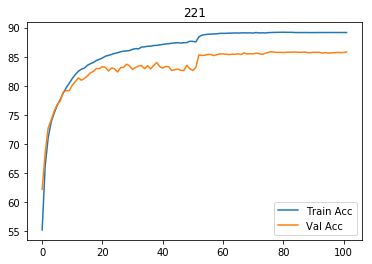

In [45]:
plt.title('221')
plt.plot(history221['acc'])
plt.plot(history221['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* * Best val Accuracy so far : 48.469 epoch : 85 *
* Hasn't learnt much why?

=====================================================

#### model 113

In [48]:
# model
torch.cuda.empty_cache()
best_acc113 = 0
em_iters = [1,1,3]
model113 = capsules(A=A, B=B, C=C, D=D, E=num_class,in_channels=1,
                 iters_routings=em_iters).to(device)
history113={'val_acc':[],'acc':[]}
optimizer113 = optim.Adam(model113.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 10, 3, 4, 1] 
iters for routings:  [1, 1, 3] 
stage output:  class_caps 
activation:  o


In [ ]:
torch.cuda.empty_cache()

best_acc113= mainTrain('model113_A',epochs,model113,history113,optimizer113)


########### Training model model113_A ###########
Train Epoch: 1	[0/60000 (0%)]	Loss: 0.456664	Accuracy: 7.812500	
Train Epoch: 1	[6400/60000 (11%)]	Loss: 0.098164	Accuracy: 67.187500	
Train Epoch: 1	[12800/60000 (21%)]	Loss: 0.061192	Accuracy: 78.906250	
Train Epoch: 1	[19200/60000 (32%)]	Loss: 0.071671	Accuracy: 67.968750	
Train Epoch: 1	[25600/60000 (43%)]	Loss: 0.043496	Accuracy: 82.812500	
Train Epoch: 1	[32000/60000 (53%)]	Loss: 0.057635	Accuracy: 75.781250	
Train Epoch: 1	[38400/60000 (64%)]	Loss: 0.043567	Accuracy: 78.906250	
Train Epoch: 1	[44800/60000 (75%)]	Loss: 0.043989	Accuracy: 80.468750	
Train Epoch: 1	[51200/60000 (85%)]	Loss: 0.052539	Accuracy: 78.125000	
Train Epoch: 1	[57600/60000 (96%)]	Loss: 0.038616	Accuracy: 80.468750	
Epoch Train-loss : 0.0646, Epoch Train-accuracy : 73.8467
Test Completion: [------------------> ] 95%
Test set: Average loss: 4.214910, Accuracy: 78.444393 


saving model to FMnist_weights\model_model113_A_1.pth
Current Learning Rate : 0.00099904

Train Epoch: 8	[6400/60000 (11%)]	Loss: 0.040642	Accuracy: 86.718750	
Train Epoch: 8	[12800/60000 (21%)]	Loss: 0.024459	Accuracy: 88.281250	
Train Epoch: 8	[19200/60000 (32%)]	Loss: 0.037682	Accuracy: 82.031250	
Train Epoch: 8	[25600/60000 (43%)]	Loss: 0.020042	Accuracy: 90.625000	
Train Epoch: 8	[32000/60000 (53%)]	Loss: 0.036275	Accuracy: 84.375000	
Train Epoch: 8	[38400/60000 (64%)]	Loss: 0.030807	Accuracy: 89.062500	
Train Epoch: 8	[44800/60000 (75%)]	Loss: 0.034449	Accuracy: 84.375000	
Train Epoch: 8	[51200/60000 (85%)]	Loss: 0.039147	Accuracy: 85.156250	
Train Epoch: 8	[57600/60000 (96%)]	Loss: 0.023378	Accuracy: 90.625000	
Epoch Train-loss : 0.0295, Epoch Train-accuracy : 87.3878
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.452497, Accuracy: 85.904756 


saving model to FMnist_weights\model_model113_A_8.pth
Current Learning Rate : 0.000992371043175416
* Best val Accuracy so far : 85.905 epoch : 8 *
Total 1 epochs with no improvement in val_acc.
Epoch tim

Train Epoch: 15	[12800/60000 (21%)]	Loss: 0.020322	Accuracy: 92.187500	
Train Epoch: 15	[19200/60000 (32%)]	Loss: 0.032345	Accuracy: 86.718750	
Train Epoch: 15	[25600/60000 (43%)]	Loss: 0.017038	Accuracy: 93.750000	
Train Epoch: 15	[32000/60000 (53%)]	Loss: 0.039696	Accuracy: 85.937500	
Train Epoch: 15	[38400/60000 (64%)]	Loss: 0.030283	Accuracy: 89.843750	
Train Epoch: 15	[44800/60000 (75%)]	Loss: 0.034790	Accuracy: 85.156250	
Train Epoch: 15	[51200/60000 (85%)]	Loss: 0.036063	Accuracy: 89.062500	
Train Epoch: 15	[57600/60000 (96%)]	Loss: 0.028456	Accuracy: 89.843750	
Epoch Train-loss : 0.0278, Epoch Train-accuracy : 89.7144
Test Completion: [------------------> ] 95%
Test set: Average loss: 3.131770, Accuracy: 86.784237 


saving model to FMnist_weights\model_model113_A_15.pth
Current Learning Rate : 0.0009857434641560286
* Best val Accuracy so far : 86.814 epoch : 13 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 4.68 mins
Train Epoch: 16	[0/60000 (0%)]	Loss: 0.018571	

Train Epoch: 22	[12800/60000 (21%)]	Loss: 0.018299	Accuracy: 91.406250	
Train Epoch: 22	[19200/60000 (32%)]	Loss: 0.035188	Accuracy: 86.718750	
Train Epoch: 22	[25600/60000 (43%)]	Loss: 0.019344	Accuracy: 94.531250	
Train Epoch: 22	[32000/60000 (53%)]	Loss: 0.039542	Accuracy: 88.281250	
Train Epoch: 22	[38400/60000 (64%)]	Loss: 0.033538	Accuracy: 89.843750	
Train Epoch: 22	[44800/60000 (75%)]	Loss: 0.035938	Accuracy: 85.156250	
Train Epoch: 22	[51200/60000 (85%)]	Loss: 0.031203	Accuracy: 91.406250	
Train Epoch: 22	[57600/60000 (96%)]	Loss: 0.033850	Accuracy: 89.843750	
Epoch Train-loss : 0.0280, Epoch Train-accuracy : 91.1014
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.949359, Accuracy: 87.203010 


saving model to FMnist_weights\model_model113_A_22.pth
Current Learning Rate : 0.00097916014761685
* Best val Accuracy so far : 87.203 epoch : 22 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 4.67 mins
Train Epoch: 23	[0/60000 (0%)]	Loss: 0.019750	Ac

Train Epoch: 29	[12800/60000 (21%)]	Loss: 0.019613	Accuracy: 92.968750	
Train Epoch: 29	[19200/60000 (32%)]	Loss: 0.030788	Accuracy: 89.843750	
Train Epoch: 29	[25600/60000 (43%)]	Loss: 0.022546	Accuracy: 93.750000	
Train Epoch: 29	[32000/60000 (53%)]	Loss: 0.042102	Accuracy: 89.062500	
Train Epoch: 29	[38400/60000 (64%)]	Loss: 0.031121	Accuracy: 92.968750	
Train Epoch: 29	[44800/60000 (75%)]	Loss: 0.039441	Accuracy: 89.062500	
Train Epoch: 29	[51200/60000 (85%)]	Loss: 0.029936	Accuracy: 92.968750	
Train Epoch: 29	[57600/60000 (96%)]	Loss: 0.035002	Accuracy: 87.500000	
Epoch Train-loss : 0.0291, Epoch Train-accuracy : 92.1997
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.829917, Accuracy: 87.692440 


saving model to FMnist_weights\model_model113_A_29.pth
Current Learning Rate : 0.000972620797949612
* Best val Accuracy so far : 87.761 epoch : 27 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 4.65 mins
Train Epoch: 30	[0/60000 (0%)]	Loss: 0.018921	A

Train Epoch: 36	[12800/60000 (21%)]	Loss: 0.018083	Accuracy: 96.875000	
Train Epoch: 36	[19200/60000 (32%)]	Loss: 0.035729	Accuracy: 92.187500	
Train Epoch: 36	[25600/60000 (43%)]	Loss: 0.024312	Accuracy: 94.531250	
Train Epoch: 36	[32000/60000 (53%)]	Loss: 0.038493	Accuracy: 90.625000	
Train Epoch: 36	[38400/60000 (64%)]	Loss: 0.032911	Accuracy: 93.750000	
Train Epoch: 36	[44800/60000 (75%)]	Loss: 0.038284	Accuracy: 90.625000	
Train Epoch: 36	[51200/60000 (85%)]	Loss: 0.026556	Accuracy: 94.531250	
Train Epoch: 36	[57600/60000 (96%)]	Loss: 0.033776	Accuracy: 90.625000	
Epoch Train-loss : 0.0300, Epoch Train-accuracy : 93.2902
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.747407, Accuracy: 87.703929 


saving model to FMnist_weights\model_model113_A_36.pth
Current Learning Rate : 0.0009661251215202755
* Best val Accuracy so far : 87.764 epoch : 30 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 4.66 mins
Train Epoch: 37	[0/60000 (0%)]	Loss: 0.018359	

Train Epoch: 43	[12800/60000 (21%)]	Loss: 0.015470	Accuracy: 96.875000	
Train Epoch: 43	[19200/60000 (32%)]	Loss: 0.035152	Accuracy: 93.750000	
Train Epoch: 43	[25600/60000 (43%)]	Loss: 0.030732	Accuracy: 93.750000	
Train Epoch: 43	[32000/60000 (53%)]	Loss: 0.040405	Accuracy: 89.062500	
Train Epoch: 43	[38400/60000 (64%)]	Loss: 0.035236	Accuracy: 94.531250	
Train Epoch: 43	[44800/60000 (75%)]	Loss: 0.036209	Accuracy: 93.750000	
Train Epoch: 43	[51200/60000 (85%)]	Loss: 0.024970	Accuracy: 98.437500	
Train Epoch: 43	[57600/60000 (96%)]	Loss: 0.034204	Accuracy: 96.093750	
Epoch Train-loss : 0.0312, Epoch Train-accuracy : 94.1115
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.661749, Accuracy: 88.237592 


saving model to FMnist_weights\model_model113_A_43.pth
Current Learning Rate : 0.0009596728266558442
* Best val Accuracy so far : 88.238 epoch : 43 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 4.66 mins
Train Epoch: 44	[0/60000 (0%)]	Loss: 0.017935	

Train Epoch: 50	[12800/60000 (21%)]	Loss: 0.017860	Accuracy: 96.093750	
Train Epoch: 50	[19200/60000 (32%)]	Loss: 0.035808	Accuracy: 92.187500	
Train Epoch: 50	[25600/60000 (43%)]	Loss: 0.032276	Accuracy: 96.093750	
Train Epoch: 50	[32000/60000 (53%)]	Loss: 0.047163	Accuracy: 90.625000	
Train Epoch: 50	[38400/60000 (64%)]	Loss: 0.038063	Accuracy: 95.312500	
Train Epoch: 50	[44800/60000 (75%)]	Loss: 0.042430	Accuracy: 93.750000	
Train Epoch: 50	[51200/60000 (85%)]	Loss: 0.024693	Accuracy: 99.218750	
Train Epoch: 50	[57600/60000 (96%)]	Loss: 0.034514	Accuracy: 96.875000	
Epoch Train-loss : 0.0336, Epoch Train-accuracy : 94.7034
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.608972, Accuracy: 88.225528 


saving model to FMnist_weights\model_model113_A_50.pth
Current Learning Rate : 0.0009532636236312693
* Best val Accuracy so far : 88.415 epoch : 47 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 4.66 mins
Train Epoch: 51	[0/60000 (0%)]	Loss: 0.020314	

Train Epoch: 57	[12800/60000 (21%)]	Loss: 0.024987	Accuracy: 96.093750	
Train Epoch: 57	[19200/60000 (32%)]	Loss: 0.037823	Accuracy: 92.968750	
Train Epoch: 57	[25600/60000 (43%)]	Loss: 0.039756	Accuracy: 92.968750	
Train Epoch: 57	[32000/60000 (53%)]	Loss: 0.049961	Accuracy: 90.625000	
Train Epoch: 57	[38400/60000 (64%)]	Loss: 0.042826	Accuracy: 96.093750	
Train Epoch: 57	[44800/60000 (75%)]	Loss: 0.039654	Accuracy: 95.312500	
Train Epoch: 57	[51200/60000 (85%)]	Loss: 0.027145	Accuracy: 96.875000	
Train Epoch: 57	[57600/60000 (96%)]	Loss: 0.028773	Accuracy: 97.656250	
Epoch Train-loss : 0.0362, Epoch Train-accuracy : 95.3280
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.566721, Accuracy: 87.936006 


saving model to FMnist_weights\model_model113_A_57.pth
Current Learning Rate : 0.0009468972246564383
* Best val Accuracy so far : 88.415 epoch : 47 *
Total 10 epochs with no improvement in val_acc.
Epoch time: 4.66 mins
Train Epoch: 58	[0/60000 (0%)]	Loss: 0.020288

Train Epoch: 64	[6400/60000 (11%)]	Loss: 0.047768	Accuracy: 92.968750	
Train Epoch: 64	[12800/60000 (21%)]	Loss: 0.024792	Accuracy: 96.093750	
Train Epoch: 64	[19200/60000 (32%)]	Loss: 0.047139	Accuracy: 93.750000	
Train Epoch: 64	[25600/60000 (43%)]	Loss: 0.038196	Accuracy: 94.531250	
Train Epoch: 64	[32000/60000 (53%)]	Loss: 0.055616	Accuracy: 92.968750	
Train Epoch: 64	[38400/60000 (64%)]	Loss: 0.051542	Accuracy: 95.312500	
Train Epoch: 64	[44800/60000 (75%)]	Loss: 0.040597	Accuracy: 96.093750	
Train Epoch: 64	[51200/60000 (85%)]	Loss: 0.028020	Accuracy: 97.656250	
Train Epoch: 64	[57600/60000 (96%)]	Loss: 0.044419	Accuracy: 94.531250	
Epoch Train-loss : 0.0397, Epoch Train-accuracy : 95.9077
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.487806, Accuracy: 88.488626 


saving model to FMnist_weights\model_model113_A_64.pth
Current Learning Rate : 9.405733438632542e-05
* Best val Accuracy so far : 88.493 epoch : 63 *
Total 1 epochs with no improvement in val_ac

Train Epoch: 71	[6400/60000 (11%)]	Loss: 0.057018	Accuracy: 93.750000	
Train Epoch: 71	[12800/60000 (21%)]	Loss: 0.030757	Accuracy: 96.875000	
Train Epoch: 71	[19200/60000 (32%)]	Loss: 0.057003	Accuracy: 94.531250	
Train Epoch: 71	[25600/60000 (43%)]	Loss: 0.046813	Accuracy: 96.093750	
Train Epoch: 71	[32000/60000 (53%)]	Loss: 0.068487	Accuracy: 94.531250	
Train Epoch: 71	[38400/60000 (64%)]	Loss: 0.060756	Accuracy: 95.312500	
Train Epoch: 71	[44800/60000 (75%)]	Loss: 0.048328	Accuracy: 94.531250	
Train Epoch: 71	[51200/60000 (85%)]	Loss: 0.037379	Accuracy: 96.875000	
Train Epoch: 71	[57600/60000 (96%)]	Loss: 0.050766	Accuracy: 96.093750	
Epoch Train-loss : 0.0481, Epoch Train-accuracy : 96.1876
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.462668, Accuracy: 88.529412 


saving model to FMnist_weights\model_model113_A_71.pth
Current Learning Rate : 9.342916972927977e-05
* Best val Accuracy so far : 88.589 epoch : 65 *
Total 6 epochs with no improvement in val_ac

Train Epoch: 78	[0/60000 (0%)]	Loss: 0.049849	Accuracy: 96.875000	
Train Epoch: 78	[6400/60000 (11%)]	Loss: 0.077582	Accuracy: 92.968750	
Train Epoch: 78	[12800/60000 (21%)]	Loss: 0.046323	Accuracy: 97.656250	
Train Epoch: 78	[19200/60000 (32%)]	Loss: 0.081309	Accuracy: 93.750000	
Train Epoch: 78	[25600/60000 (43%)]	Loss: 0.061599	Accuracy: 97.656250	
Train Epoch: 78	[32000/60000 (53%)]	Loss: 0.086203	Accuracy: 93.750000	
Train Epoch: 78	[38400/60000 (64%)]	Loss: 0.084889	Accuracy: 95.312500	
Train Epoch: 78	[44800/60000 (75%)]	Loss: 0.063949	Accuracy: 96.093750	
Train Epoch: 78	[51200/60000 (85%)]	Loss: 0.054053	Accuracy: 96.093750	
Train Epoch: 78	[57600/60000 (96%)]	Loss: 0.063782	Accuracy: 96.875000	
Epoch Train-loss : 0.0646, Epoch Train-accuracy : 96.3786
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.448384, Accuracy: 88.557560 


saving model to FMnist_weights\model_model113_A_78.pth
Current Learning Rate : 9.28052002882578e-06
* Best val Accuracy so far 

Train Epoch: 85	[0/60000 (0%)]	Loss: 0.074634	Accuracy: 96.875000	
Train Epoch: 85	[6400/60000 (11%)]	Loss: 0.108179	Accuracy: 92.968750	
Train Epoch: 85	[12800/60000 (21%)]	Loss: 0.071409	Accuracy: 96.875000	
Train Epoch: 85	[19200/60000 (32%)]	Loss: 0.110274	Accuracy: 94.531250	
Train Epoch: 85	[25600/60000 (43%)]	Loss: 0.090051	Accuracy: 96.875000	
Train Epoch: 85	[32000/60000 (53%)]	Loss: 0.116842	Accuracy: 93.750000	
Train Epoch: 85	[38400/60000 (64%)]	Loss: 0.115708	Accuracy: 95.312500	
Train Epoch: 85	[44800/60000 (75%)]	Loss: 0.093091	Accuracy: 96.093750	
Train Epoch: 85	[51200/60000 (85%)]	Loss: 0.082001	Accuracy: 96.093750	
Train Epoch: 85	[57600/60000 (96%)]	Loss: 0.091122	Accuracy: 97.656250	
Epoch Train-loss : 0.0926, Epoch Train-accuracy : 96.3669
Test Completion: [------------------> ] 95%
Test set: Average loss: 2.444985, Accuracy: 88.539177 


saving model to FMnist_weights\model_model113_A_85.pth
Current Learning Rate : 9.218539804538666e-07
* Best val Accuracy so far

In [ ]:
print('best test accuracy: {:.6f}'.format(best_acc113))
with open('model113_A_history.pkl','wb') as f:
    pickle.dump(history113,f)
torch.cuda.empty_cache()    

plt.plot(history113['acc'])
plt.plot(history113['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 88.589 epoch : 74 *


=====================================================